In [678]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry as geo
from collections import Counter

In [679]:
df = gpd.read_file("trips.gpkg")
df_annot = pd.read_csv("persons.csv", sep=";")

In [680]:
trips_id = df["person_id"].values.tolist()
pers_id = df_annot["person_id"].values.tolist()

In [681]:
df = df.merge(df_annot,left_on="person_id",right_on="person_id")

### Activity Chains counts

In [682]:
# mutltiindexing
mdf = df.set_index(["person_id","trip_id"])
mdf.sort_index(inplace=True)

In [683]:
# split followingPurpose into subarrays grouped by person_id
larr = np.split(mdf["following_purpose"].values,np.cumsum(mdf["following_purpose"].groupby(['person_id']).size()))

In [684]:
# getting last activity
lact=[]
for chain in larr:
    try:
        lact.append(chain[-1][0])
    except: # somehow the very last one is empty..
        lact.append("")

In [685]:
# split preceedingPurpose into subarrays grouped by person_id
arr = np.split(mdf["preceeding_purpose"].values,np.cumsum(mdf["preceeding_purpose"].groupby(['person_id']).size()))

In [686]:
# make a string describing the activity chain
str_chain=[]
for chain in arr:
    str_chain.append('-'.join([word[0] for word in chain]))

In [687]:
# append the return activity to the str_chain
str_chain = [i +"-"+ j for i, j in zip(str_chain, lact)] 

In [688]:
# create new data frame
data_tuples = list(zip(Counter(str_chain).keys(),Counter(str_chain).values()))
CC = pd.DataFrame(data_tuples, columns=['Chain','synthetic Count'])
CC = CC.sort_values(by=['synthetic Count'],ascending=False)

In [689]:
# and the same for the actuals..
adf = pd.read_csv("trips_clean_allworkdays_new7.csv",sep=",")
adf_annot = pd.read_csv("persons_clean_allworkdays_alltogether_new7.csv",sep=",")
adf.loc[adf["destination_purpose"].isna(), "destination_purpose"] = "other"
lmax = np.max(adf.groupby(["person_id"])["trip_id"])
index = [adf["trip_id"][i] == lmax[adf["person_id"][i]]  for i in range(len(adf)) ]
adf_bis_il = adf.index[np.logical_and(index, adf["destination_purpose"]!= "Home")]
adf_bis_i = adf.index.isin(adf_bis_il)
adf_bis = adf[~adf_bis_i]


In [690]:
adf.loc[adf["destination_purpose"] == "errand", "destination_purpose"] ="other"
adf.loc[adf["origin_purpose"] == "errand", "origin_purpose"] ="other"


In [691]:
adf.loc[adf["mode"] == "motorcycle", "mode"] = "car"
adf.loc[adf["mode"] == "taxi", "mode"] = "taxi"
adf.loc[adf["mode"] == "ride_hailing", "mode"] = "taxi"
adf = adf[~(adf["mode"] == "bike")]
adf = adf[~(adf["mode"] == "other")]
#adf.loc[adf["mode"] == "bike", "mode"] = "walk"
#adf.loc[adf["mode"] == "other", "mode"] = "walk"

In [692]:
adf = adf.merge(adf_annot[["person_id", "weight_person", "employed", "age", "household_income", "gender", "number_of_cars"]],on=["person_id"],how='left')
adf.loc[(adf["destination_purpose"]=='work') & (adf["age"] < 16), "destination_purpose"]="other"
adf.loc[(adf["origin_purpose"]=='work') & (adf["age"] < 16), "origin_purpose"]="other"

In [693]:
#his = adf[(adf["employed"]!='student') & (adf["destination_purpose"]=='education')]['age'].plot.hist(bins=12)

In [694]:
#only keep the persons that could have been used in activity chain matching
adf = adf[~adf["weight_person"].isna()]


In [695]:
#adf["person_id2"]=adf["person_id"]
amdf = adf.set_index(["person_id"])
amdf.sort_index(inplace=True)

In [696]:
amdf["origin_purpose_first"] = amdf["origin_purpose"].apply(lambda x: x[0])
amdf["destination_purpose_first"] = amdf["destination_purpose"].apply(lambda x: x[0])

In [697]:
df2 = amdf[["origin_purpose_first", "destination_purpose_first", "weight_person"]].groupby("person_id")[
    ["origin_purpose_first", "destination_purpose_first",]
].apply(lambda x: "-".join(x["origin_purpose_first"]) + "-" + x["destination_purpose_first"].iloc[-1]).reset_index(name = "chain")

In [698]:
df3 = pd.merge(amdf["weight_person"].reset_index(), df2).drop_duplicates("person_id")

In [699]:
#amdf.replace("Errands","Other", inplace=True)
#amdf.replace("PD","Other", inplace=True)

In [700]:
alarr = np.split(amdf["destination_purpose"].values,np.cumsum(amdf["destination_purpose"].groupby(["person_id"]).size()))

In [701]:
# getting last activity
alact=[]
for chain in alarr:
    try:
        alact.append(chain[-1][0].lower())
    except: # somehow the very last one is empty..
        alact.append("")

In [702]:
# split preceedingPurpose into subarrays grouped by person_id
aarr = np.split(amdf["origin_purpose"].values,np.cumsum(amdf["origin_purpose"].groupby(["person_id"]).size()))

In [703]:
astr_chain=[]
for chain in aarr:
    #str_chain.append('-'.join(chain))
    astr_chain.append('-'.join([word[0].lower() for word in chain]))

In [704]:
# append the return activity to the str_chain
astr_chain = [i +"-"+ j for i, j in zip(astr_chain, alact)] 

In [705]:
adata_tuples = list(zip(Counter(astr_chain).keys(),Counter(astr_chain).values()))


In [706]:
aCC = pd.DataFrame(adata_tuples, columns=['Chain','actual Count'])
aCC = aCC.sort_values(by=['actual Count'],ascending=False)

In [707]:
aCC_df3 = df3[["weight_person", "chain"]].groupby("chain").sum().reset_index().sort_values(
    by = "weight_person", ascending = False
).rename(columns = { "chain": "Chain", "weight_person": "actual Count" })

In [708]:
dfm = pd.merge(aCC, aCC_df3, on = "Chain", suffixes = ["_old", "_new"])

In [709]:
aCC = aCC_df3

In [710]:
# merging together
allCC = CC.merge(aCC,on="Chain", how="left")

In [711]:
# get percentages
allCC["synthetic Count"] = allCC ["synthetic Count"] / allCC["synthetic Count"].sum() *100
allCC["actual Count"] = allCC["actual Count"] / allCC["actual Count"].sum() *100

In [712]:
allCC = allCC.sort_values(by=['actual Count'],ascending=False)

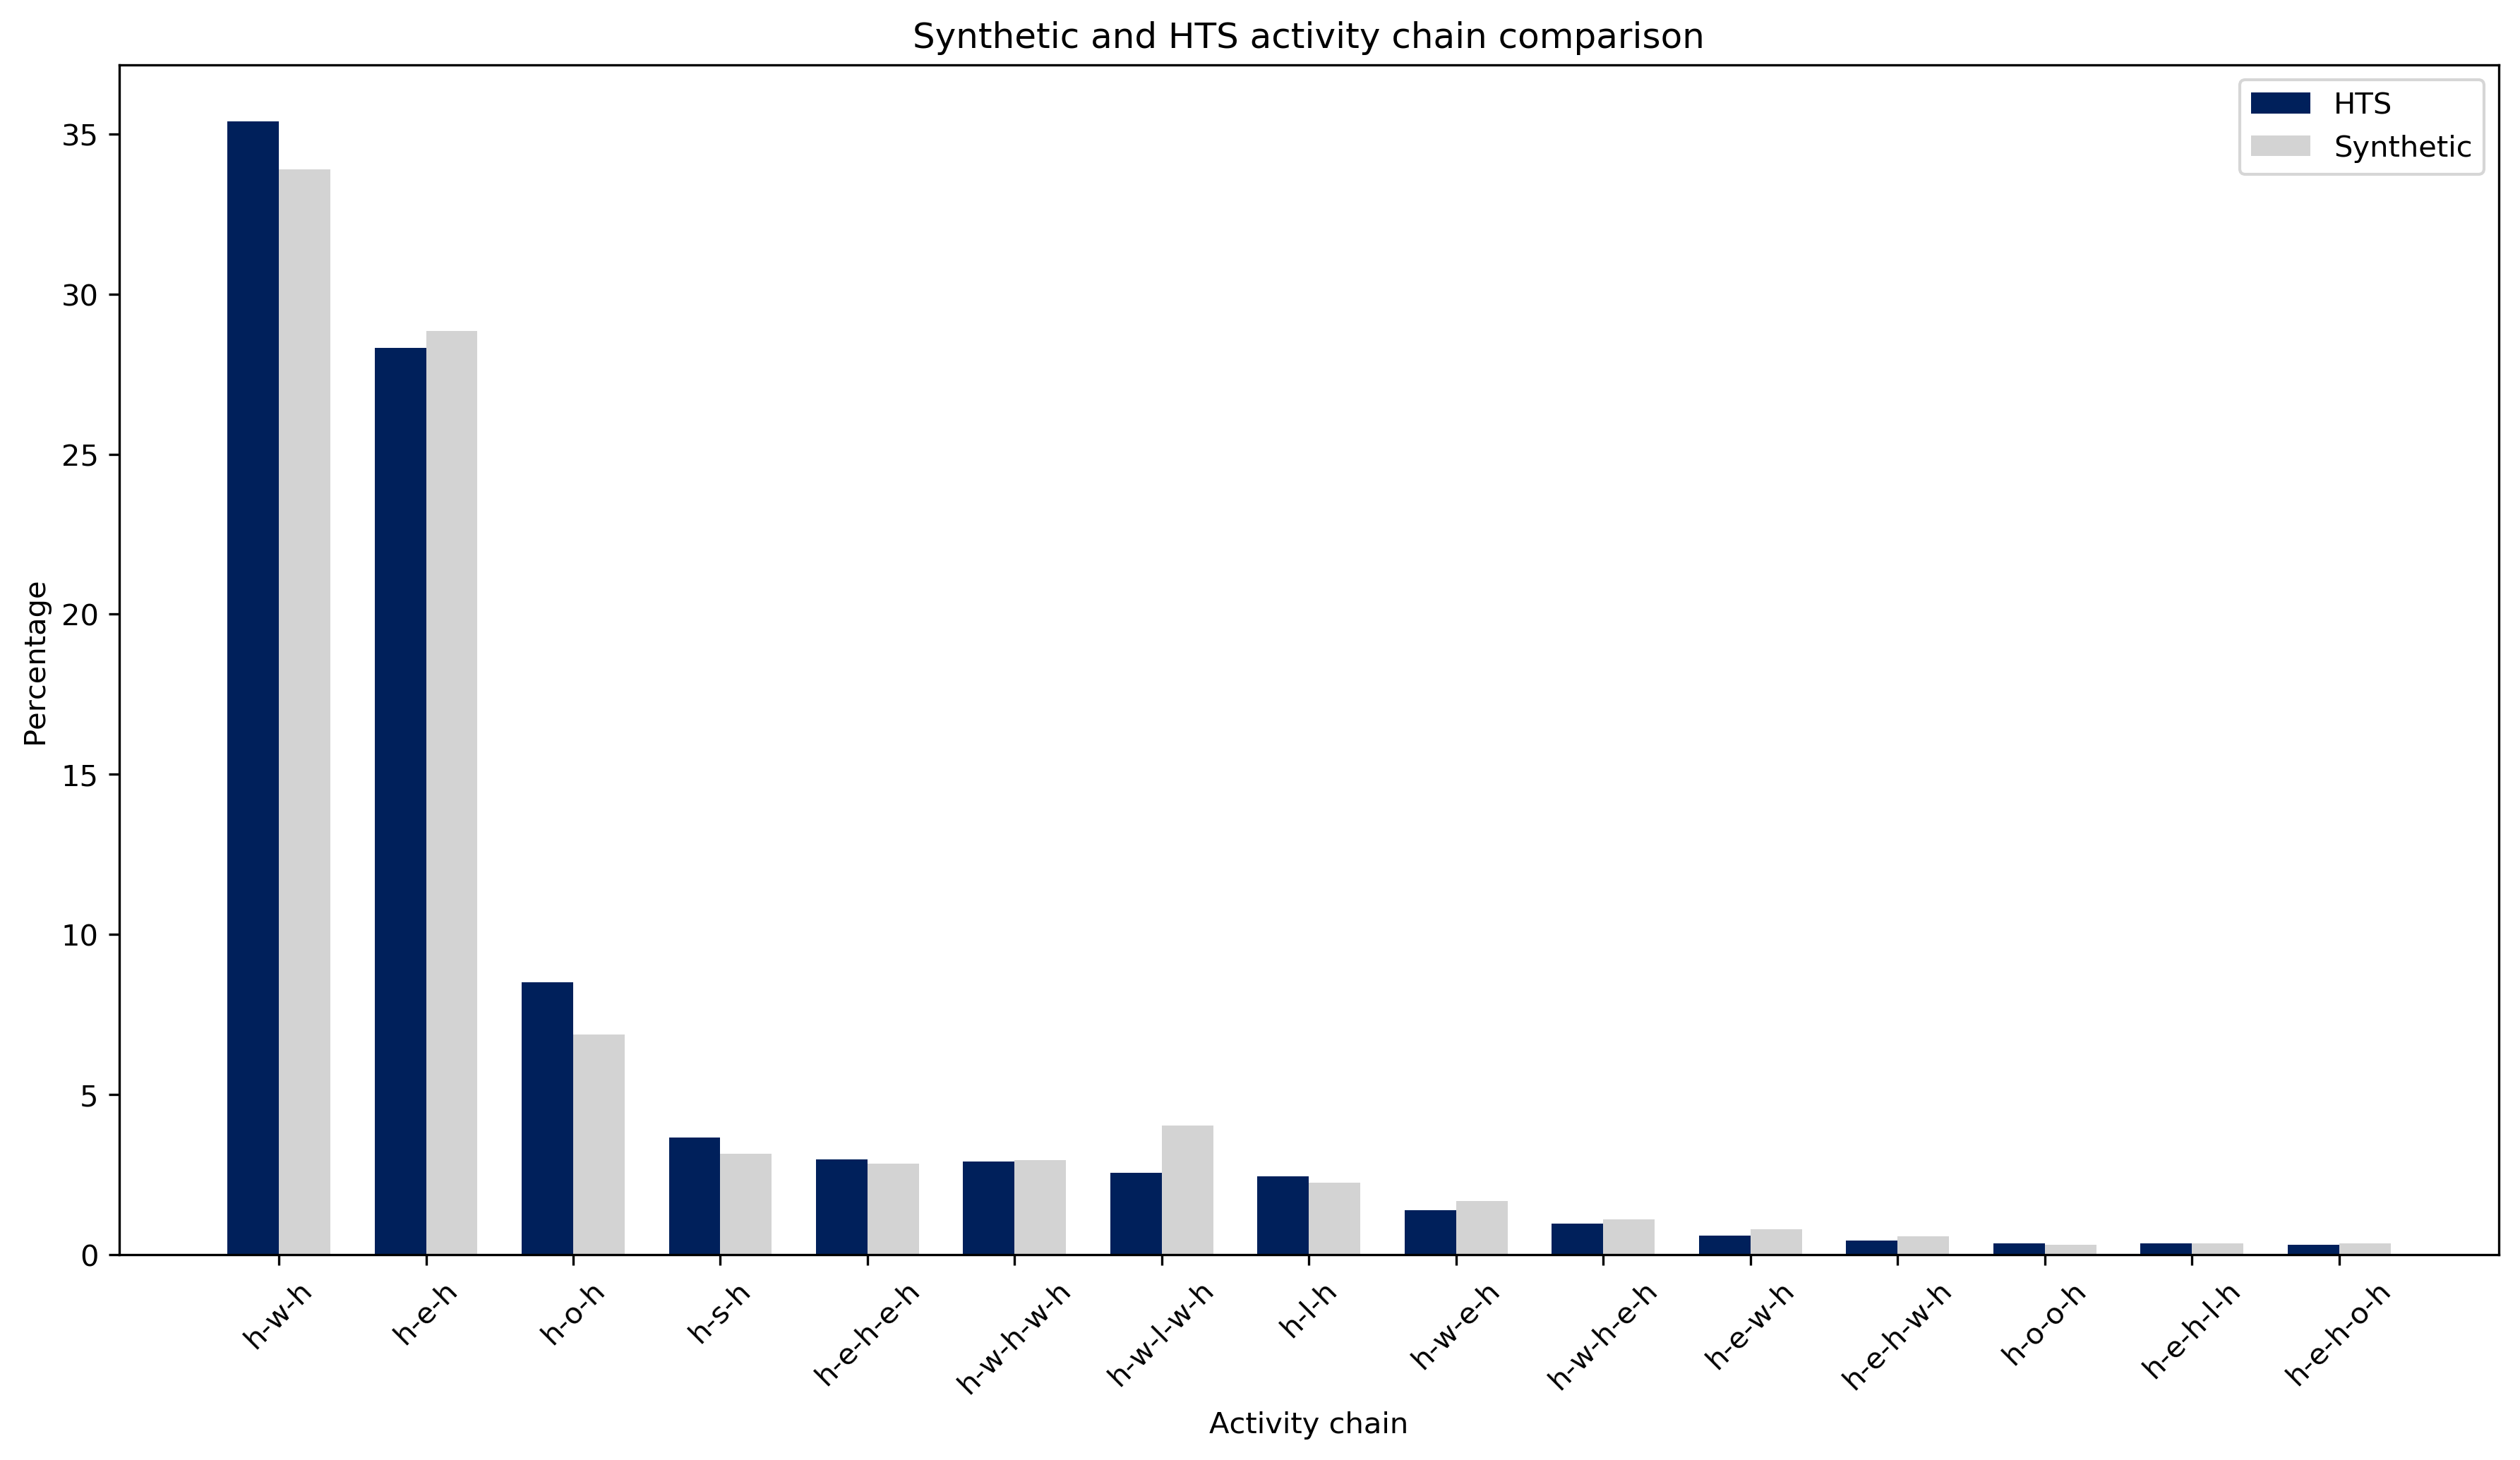

In [713]:
plt.rcParams['axes.facecolor'] = "#ffffff"
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['figure.dpi'] = 300

top = 15
labels = allCC["Chain"][:top]
men_means = allCC["actual Count"][:top]
women_means = allCC["synthetic Count"][:top]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
fig.set_facecolor("#ffffff")

rects1 = ax.bar(x - width/2, men_means, width, label='HTS',color="#00205B")
rects2 = ax.bar(x + width/2, women_means, width, label='Synthetic',color="#D3D3D3")

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


#autolabel(rects1)
#autolabel(rects2)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Synthetic and HTS activity chain comparison')
ax.set_xlabel("Activity chain")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.xticks(rotation=45)
fig.tight_layout()
plt.savefig("activitychains.png")

### Grouped by Mode and Destination purpose

In [714]:
types = df.groupby(["mode","following_purpose"]).count()["person_id"]

In [715]:
amdf.loc[amdf["mode"]=='car_passanger', "mode"]='car_passenger'

In [716]:
which = ["car","car_passenger","pt", "taxi","walk"]
atypes = amdf.groupby(["mode","destination_purpose"]).sum().loc[which,"weight_person"].reindex(index=which, level=0)

In [717]:
act = atypes / atypes.sum()
syn = types / types.sum()

In [718]:
lista = [item for item in list(types.index.levels[0]) for i in range(len(types.index.levels[1]))]
listb = list(types.index.levels[1]) * len(types.index.levels[0])
labels = [a+" "+b for a,b in zip(lista,listb)]

In [719]:
syn

mode           following_purpose
car            education            0.022422
               home                 0.099179
               leisure              0.007569
               other                0.012167
               shop                 0.006922
               work                 0.067284
car_passenger  education            0.020985
               home                 0.038942
               leisure              0.005009
               other                0.007909
               shop                 0.003336
               work                 0.009343
pt             education            0.058735
               home                 0.163405
               leisure              0.005401
               other                0.020705
               shop                 0.005956
               work                 0.087028
taxi           education            0.001434
               home                 0.008500
               leisure              0.001306
               other  

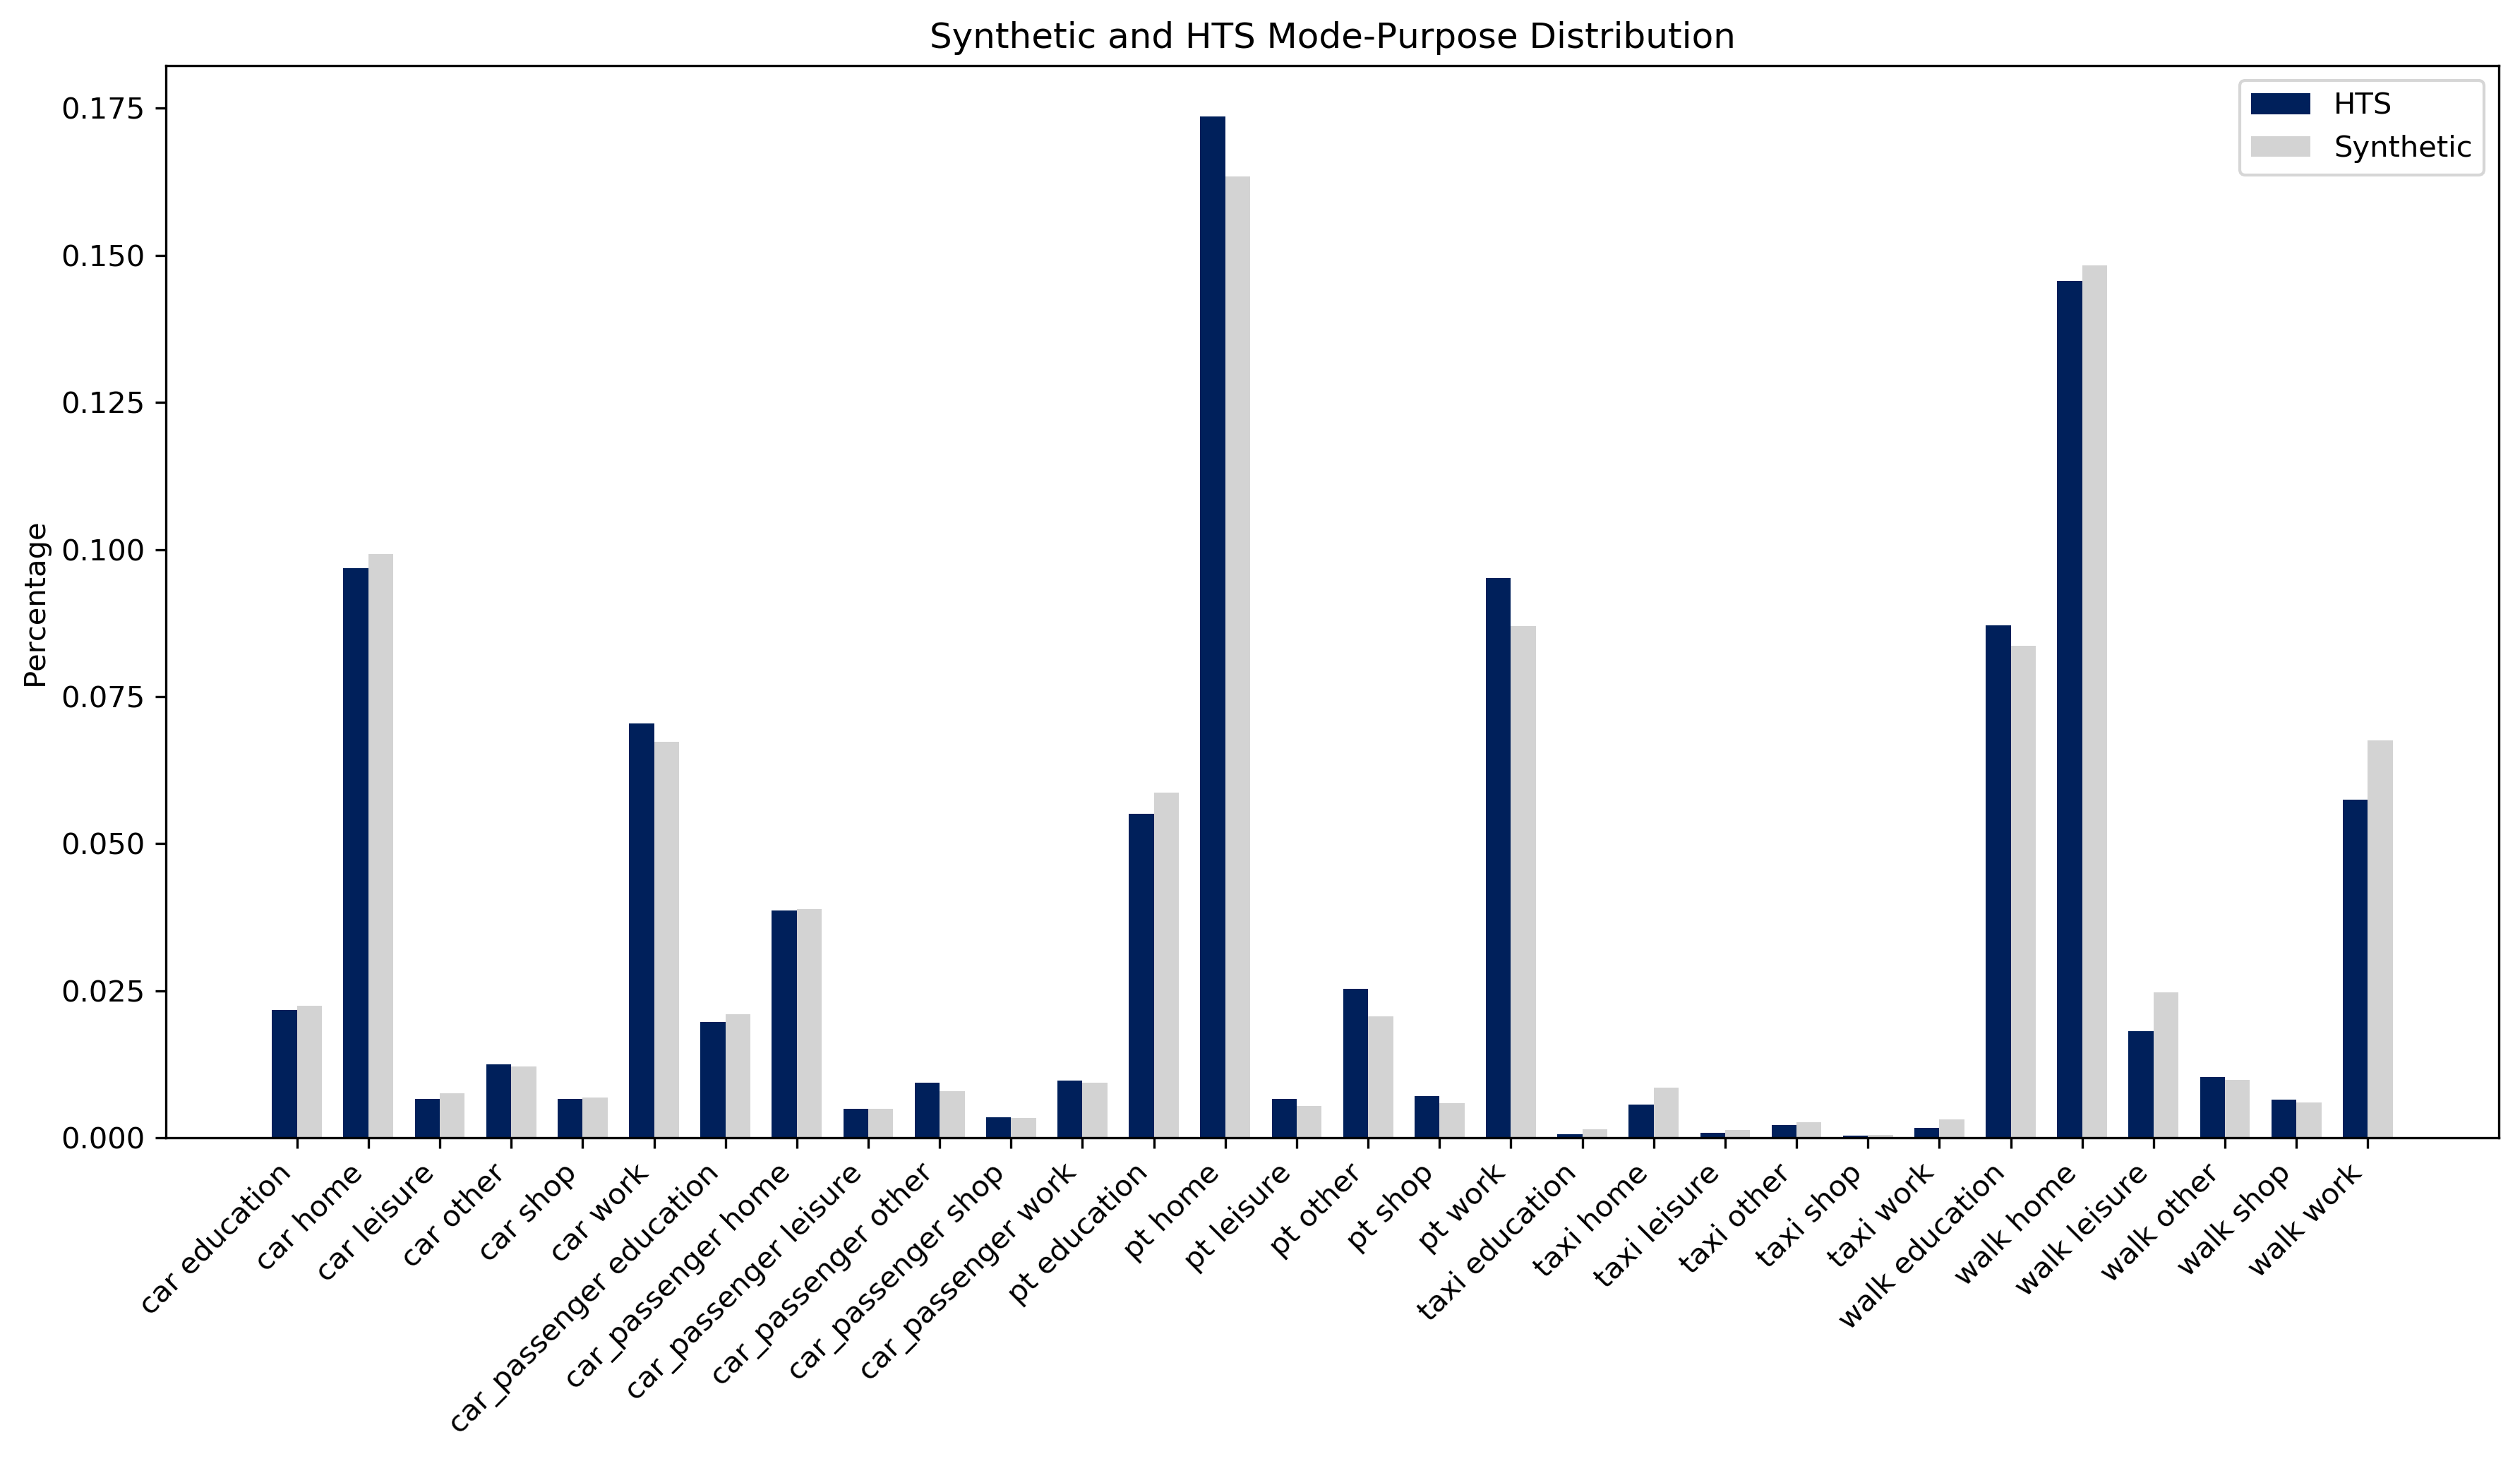

In [720]:
plt.rcParams['axes.facecolor'] = "#ffffff"
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['figure.dpi'] = 300

top = 10
labels = labels
men_means = act.values.tolist()
women_means = syn.values.tolist()


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
fig.set_facecolor("#ffffff")

rects1 = ax.bar(x - width/2, men_means, width, label='HTS',color="#00205B")
rects2 = ax.bar(x + width/2, women_means, width, label='Synthetic',color="#D3D3D3")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Synthetic and HTS Mode-Purpose Distribution')
#ax.set_xlabel("Destination Purpose")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend()

fig.tight_layout()
plt.xticks(rotation=45)
plt.savefig("modepurpose.png")

plt.show()

### Group by Gender

### Crowfly distance

In [721]:
amdf["crowfly_distance"] = 0.001 * np.sqrt(
        (amdf["origin_x"] - amdf["destination_x"])**2 + (amdf["origin_y"] - amdf["destination_y"])**2
    )


In [722]:
amdf

,origin_zone,origin_purpose,origin_x,origin_y,destination_zone,destination_x,destination_y,destination_purpose,mode,departure_h,...,Mode1,weight_person,employed,age,household_income,gender,number_of_cars,origin_purpose_first,destination_purpose_first,crowfly_distance
person_id,,,,,,,,,,,,,,,,,,,,,
10001101,1,home,333743,7394463,3,333104,7394476,work,walk,5,...,16,19.532274,yes,59,2732.58,2,0.0,h,w,0.639132
10001101,3,work,333104,7394476,1,333743,7394463,home,walk,15,...,16,19.532274,yes,59,2732.58,2,0.0,w,h,0.639132
10001102,1,home,333743,7394463,82,327503,7392159,work,pt,9,...,1,16.663976,yes,21,2732.58,2,0.0,h,w,6.651768
10001102,82,work,327503,7392159,84,329431,7395939,education,pt,17,...,1,16.663976,yes,21,2732.58,2,0.0,w,e,4.243299
10001102,84,education,329431,7395939,1,333743,7394463,home,taxi,22,...,12,16.663976,yes,21,2732.58,2,0.0,e,h,4.557622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5171418104,517,education,294735,7410561,517,294618,7410518,home,walk,12,...,16,78.835332,student,11,3000.00,1,0.0,e,h,0.124652
5171599101,517,home,295243,7411456,517,295327,7410920,work,walk,7,...,16,49.023395,yes,37,3778.19,2,1.0,h,w,0.542542
5171599101,517,work,295327,7410920,517,295243,7411456,home,walk,17,...,16,49.023395,yes,37,3778.19,2,1.0,w,h,0.542542


In [723]:
df["crowfly_distance"] = df.geometry.length

In [724]:
df2 = df[df["crowfly_distance"]<25000]
amdf2 = amdf[amdf["crowfly_distance"]<25]
df2["crowfly_distance"] = df2["crowfly_distance"] *0.001

C:\APPS\Anaconda3\envs\scenarios\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [725]:
amdf2[amdf2["destination_purpose"]=='work']

,origin_zone,origin_purpose,origin_x,origin_y,destination_zone,destination_x,destination_y,destination_purpose,mode,departure_h,...,Mode1,weight_person,employed,age,household_income,gender,number_of_cars,origin_purpose_first,destination_purpose_first,crowfly_distance
person_id,,,,,,,,,,,,,,,,,,,,,
10001101,1,home,333743,7394463,3,333104,7394476,work,walk,5,...,16,19.532274,yes,59,2732.58,2,0.0,h,w,0.639132
10001102,1,home,333743,7394463,82,327503,7392159,work,pt,9,...,1,16.663976,yes,21,2732.58,2,0.0,h,w,6.651768
10002101,1,home,333814,7394428,1,333453,7394501,work,walk,8,...,16,19.532274,yes,37,3200.00,2,0.0,h,w,0.368307
10002101,1,home,333814,7394428,1,333453,7394501,work,walk,12,...,16,19.532274,yes,37,3200.00,2,0.0,h,w,0.368307
10002102,1,home,333814,7394428,1,333539,7394387,work,walk,7,...,16,19.802278,yes,19,3200.00,2,0.0,h,w,0.278040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5171418101,517,home,294618,7410518,516,303391,7405851,work,pt,7,...,6,73.527876,yes,38,3000.00,1,0.0,h,w,9.937123
5171418102,517,home,294618,7410518,517,294881,7411254,work,walk,7,...,16,73.527876,yes,37,3000.00,2,0.0,h,w,0.781579
5171418102,517,education,294735,7410561,517,294881,7411254,work,walk,13,...,16,73.527876,yes,37,3000.00,2,0.0,e,w,0.708213


In [726]:
#amdf2 = amdf2[~((amdf2["crowfly_distance"]<0.1) & (amdf2["destination_purpose"]=='work'))]

In [727]:
#amdf[((amdf["crowfly_distance"]<0.5) & (amdf["destination_purpose"]=='work'))]

In [728]:
syn = df2.groupby(["following_purpose"]).mean()["crowfly_distance"] 

In [729]:
amdf2["x"] = amdf2["weight_person"]*amdf2["crowfly_distance"]
#amdf2["x"] = amdf2["crowfly_distance"]

C:\APPS\Anaconda3\envs\scenarios\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [730]:
act = amdf2.groupby(["destination_purpose"]).sum()["x"]/amdf2.groupby(["destination_purpose"]).sum()["weight_person"]

In [731]:
labels = syn.index

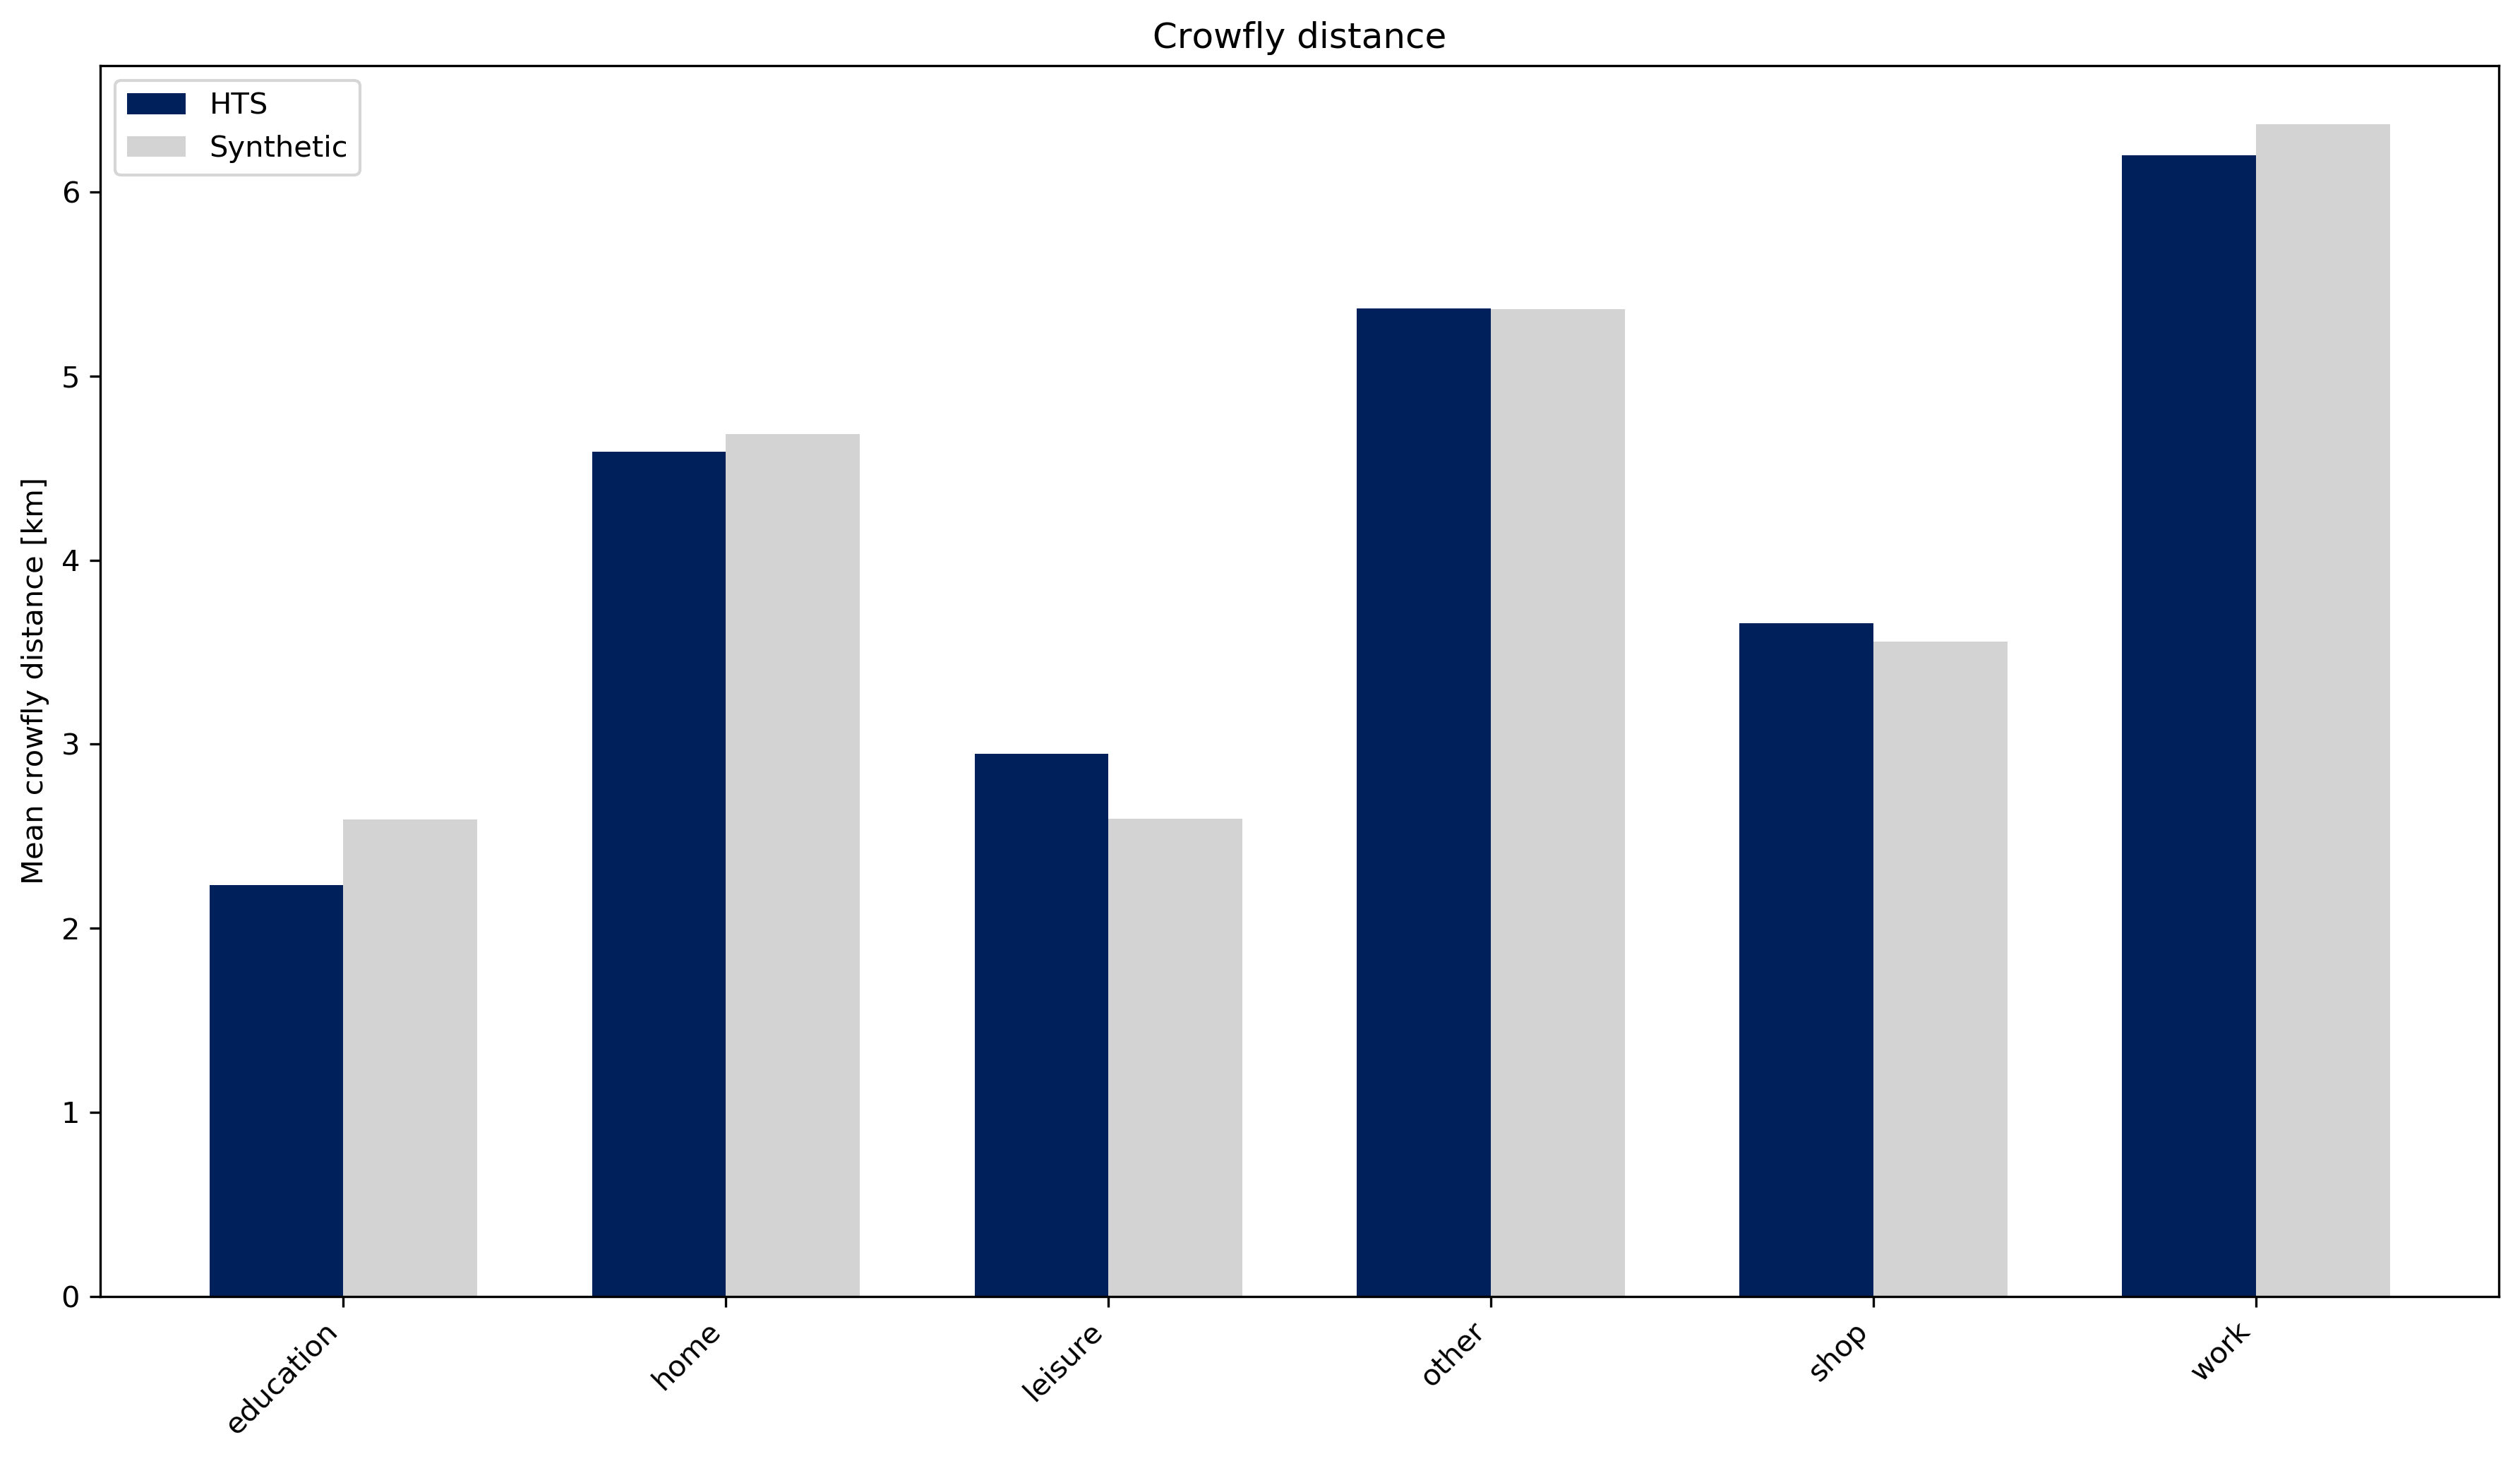

In [732]:
plt.rcParams['axes.facecolor'] = "#ffffff"
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['figure.dpi'] = 300

labels = labels
men_means = act
women_means = syn

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
fig.set_facecolor("#ffffff")

rects1 = ax.bar(x - width/2, men_means, width, label='HTS',color="#00205B")
rects2 = ax.bar(x + width/2, women_means, width, label='Synthetic',color="#D3D3D3")

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# autolabel(rects1)
# autolabel(rects2)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean crowfly distance [km]')
ax.set_title('Crowfly distance')
#ax.set_xlabel("Destination Purpose")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend()

fig.tight_layout()
plt.xticks(rotation=45)
#plt.show()
plt.savefig("distancepurpose.png")


C:\APPS\Anaconda3\envs\scenarios\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


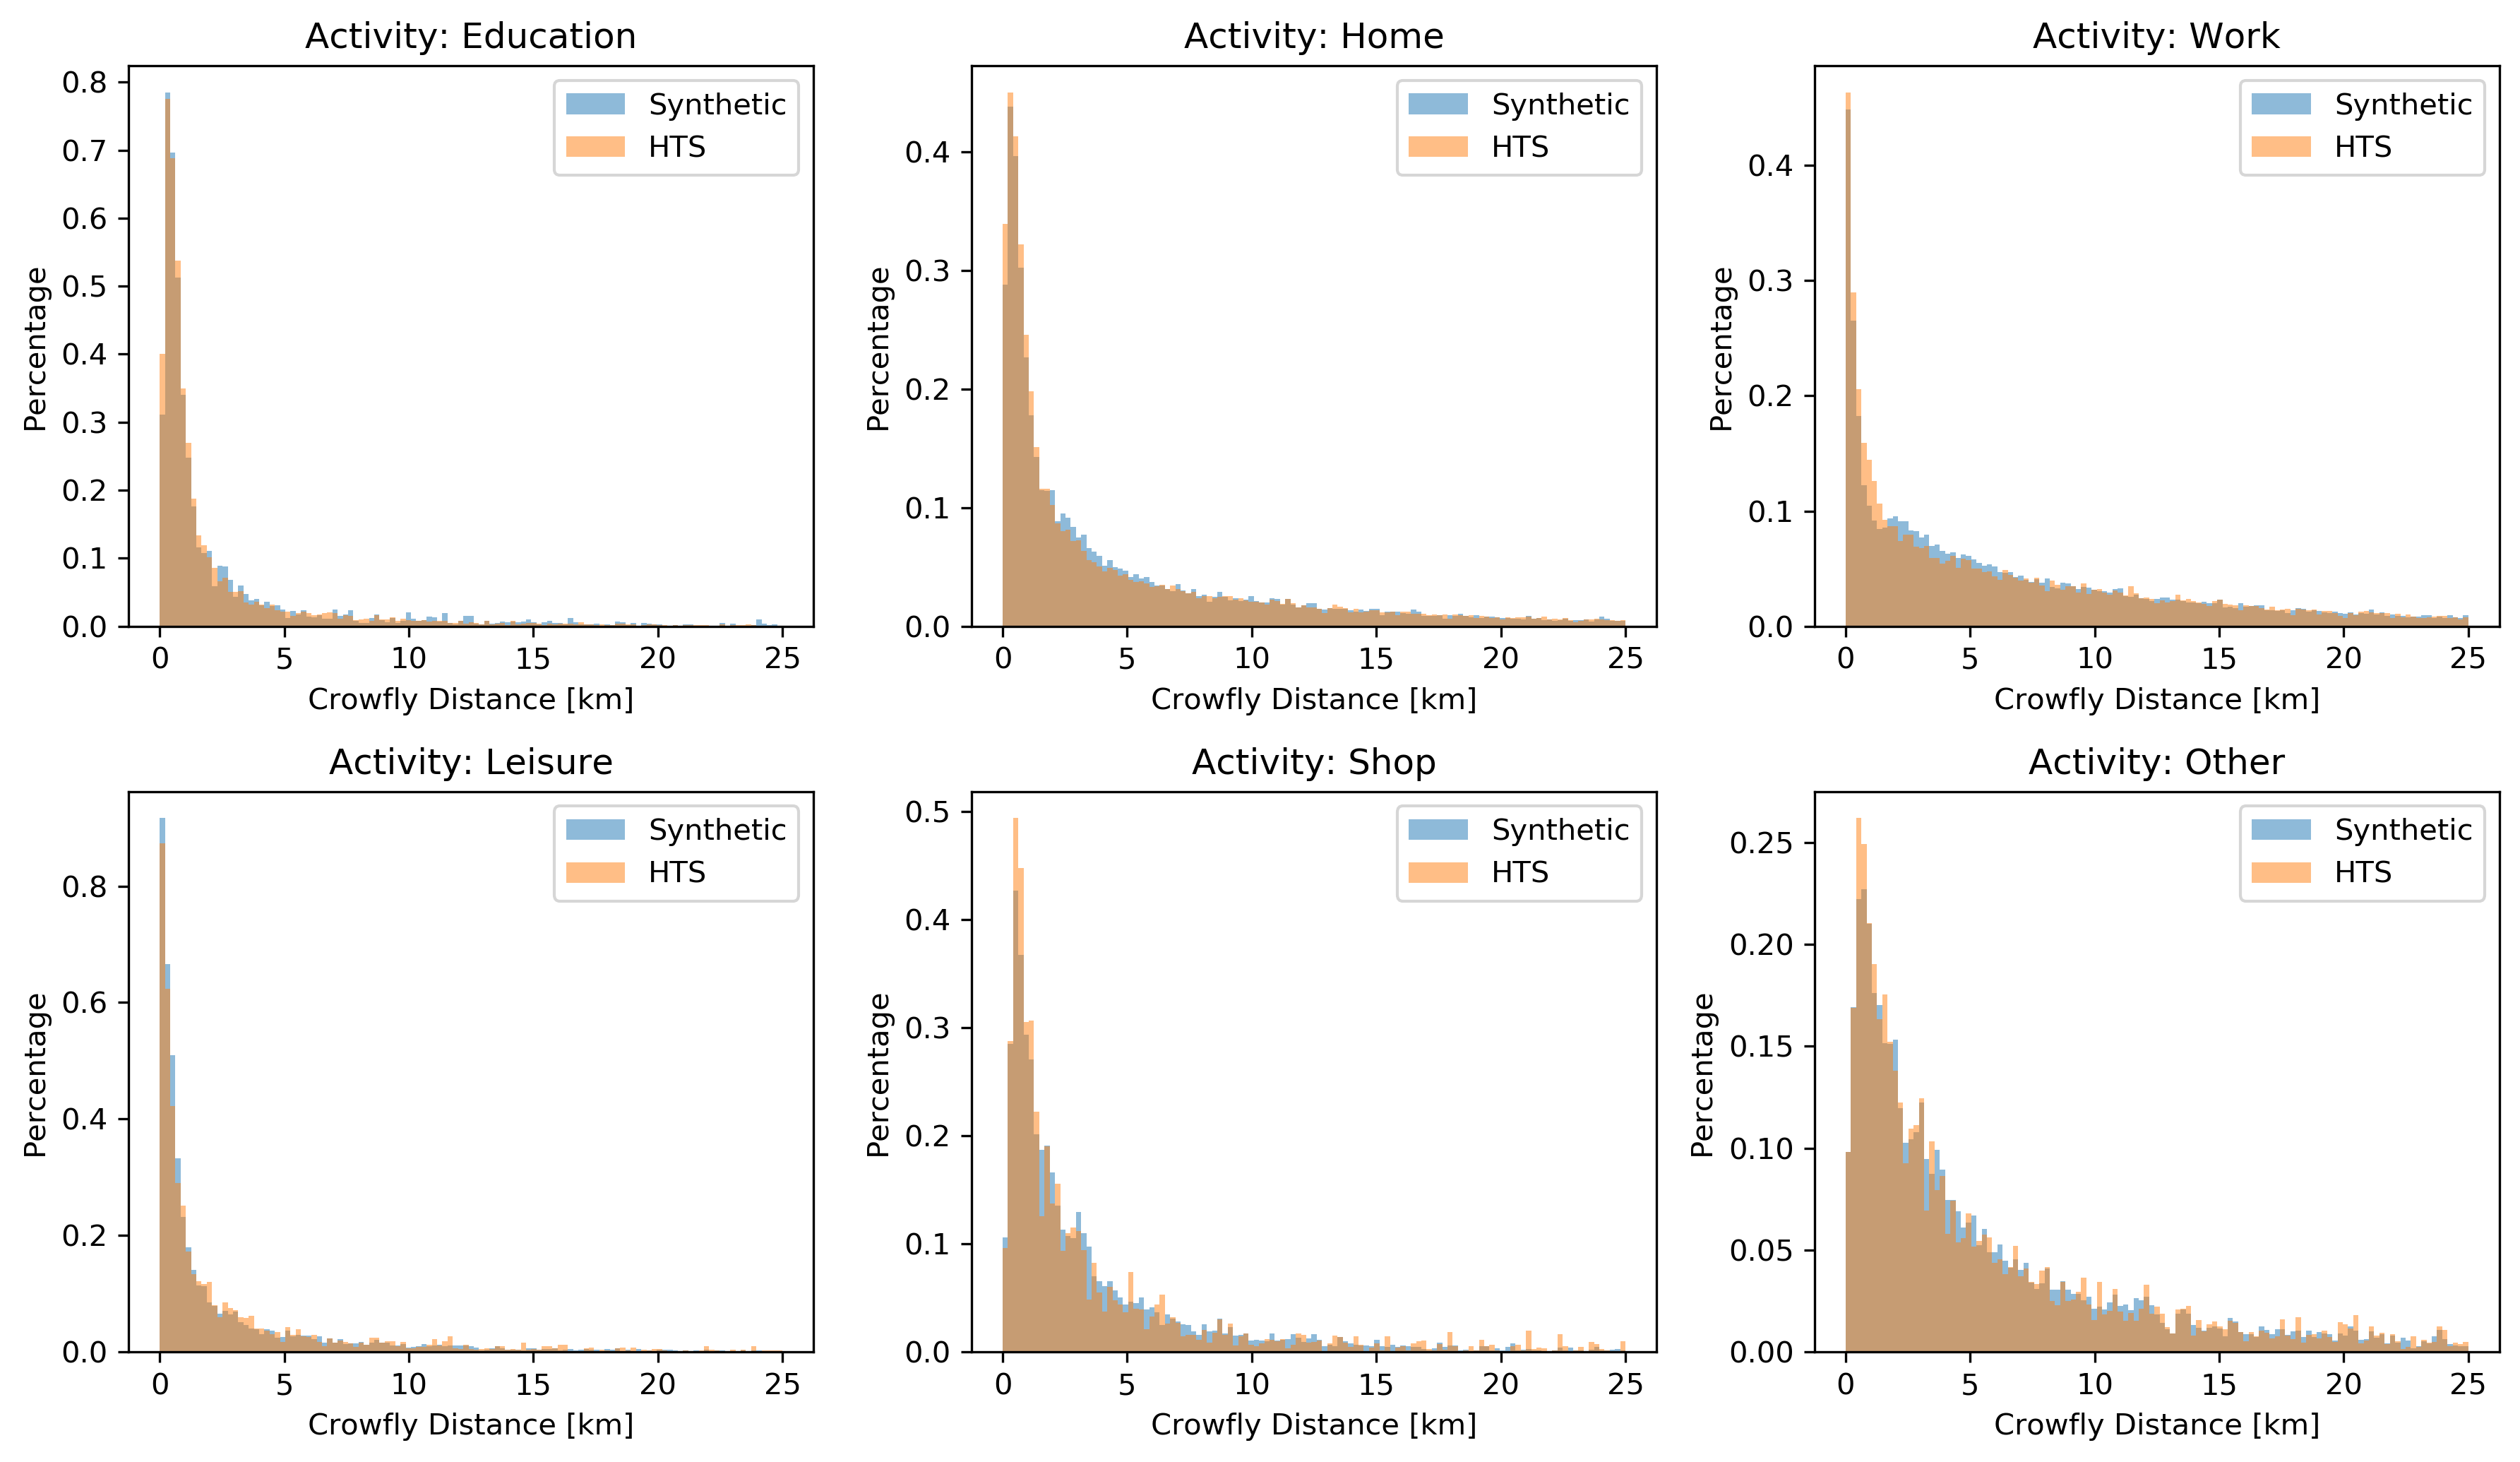

In [733]:
modelist=df2["following_purpose"].unique()
plt.rcParams['figure.dpi'] = 300

cols = 3
rows = 2

fig, axes = plt.subplots(nrows=rows, ncols=cols)
bins=np.linspace(0, 25, 120)
idx=0
for r in range(rows):
    for c in range(cols):
        x = df2[df2["following_purpose"]==modelist[idx]]["crowfly_distance"]
        if modelist[idx] =="shop":
            y = amdf2[amdf2["destination_purpose"]=="shopping"][["crowfly_distance", "weight_person"]]
        else:
            y = amdf2[amdf2["destination_purpose"]==modelist[idx]][["crowfly_distance", "weight_person"]]

        #axes[r,c].hist(x.sample(len(y)),bins,alpha=0.5,label="synthetic")
        axes[r,c].hist(x,bins,alpha=0.5,label="Synthetic",density=True)
        axes[r,c].hist(y["crowfly_distance"],bins,weights=y["weight_person"],alpha=0.5,label='HTS',density=True)
        axes[r,c].set_ylabel("Percentage")
        axes[r,c].set_xlabel("Crowfly Distance [km]")
        axes[r,c].set_title("Activity: "+modelist[idx].capitalize())
        axes[r,c].legend(loc="best")
        
        idx=idx+1
        
fig.tight_layout()
fig.show()
plt.savefig("distancepurposehist.png")


C:\APPS\Anaconda3\envs\scenarios\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


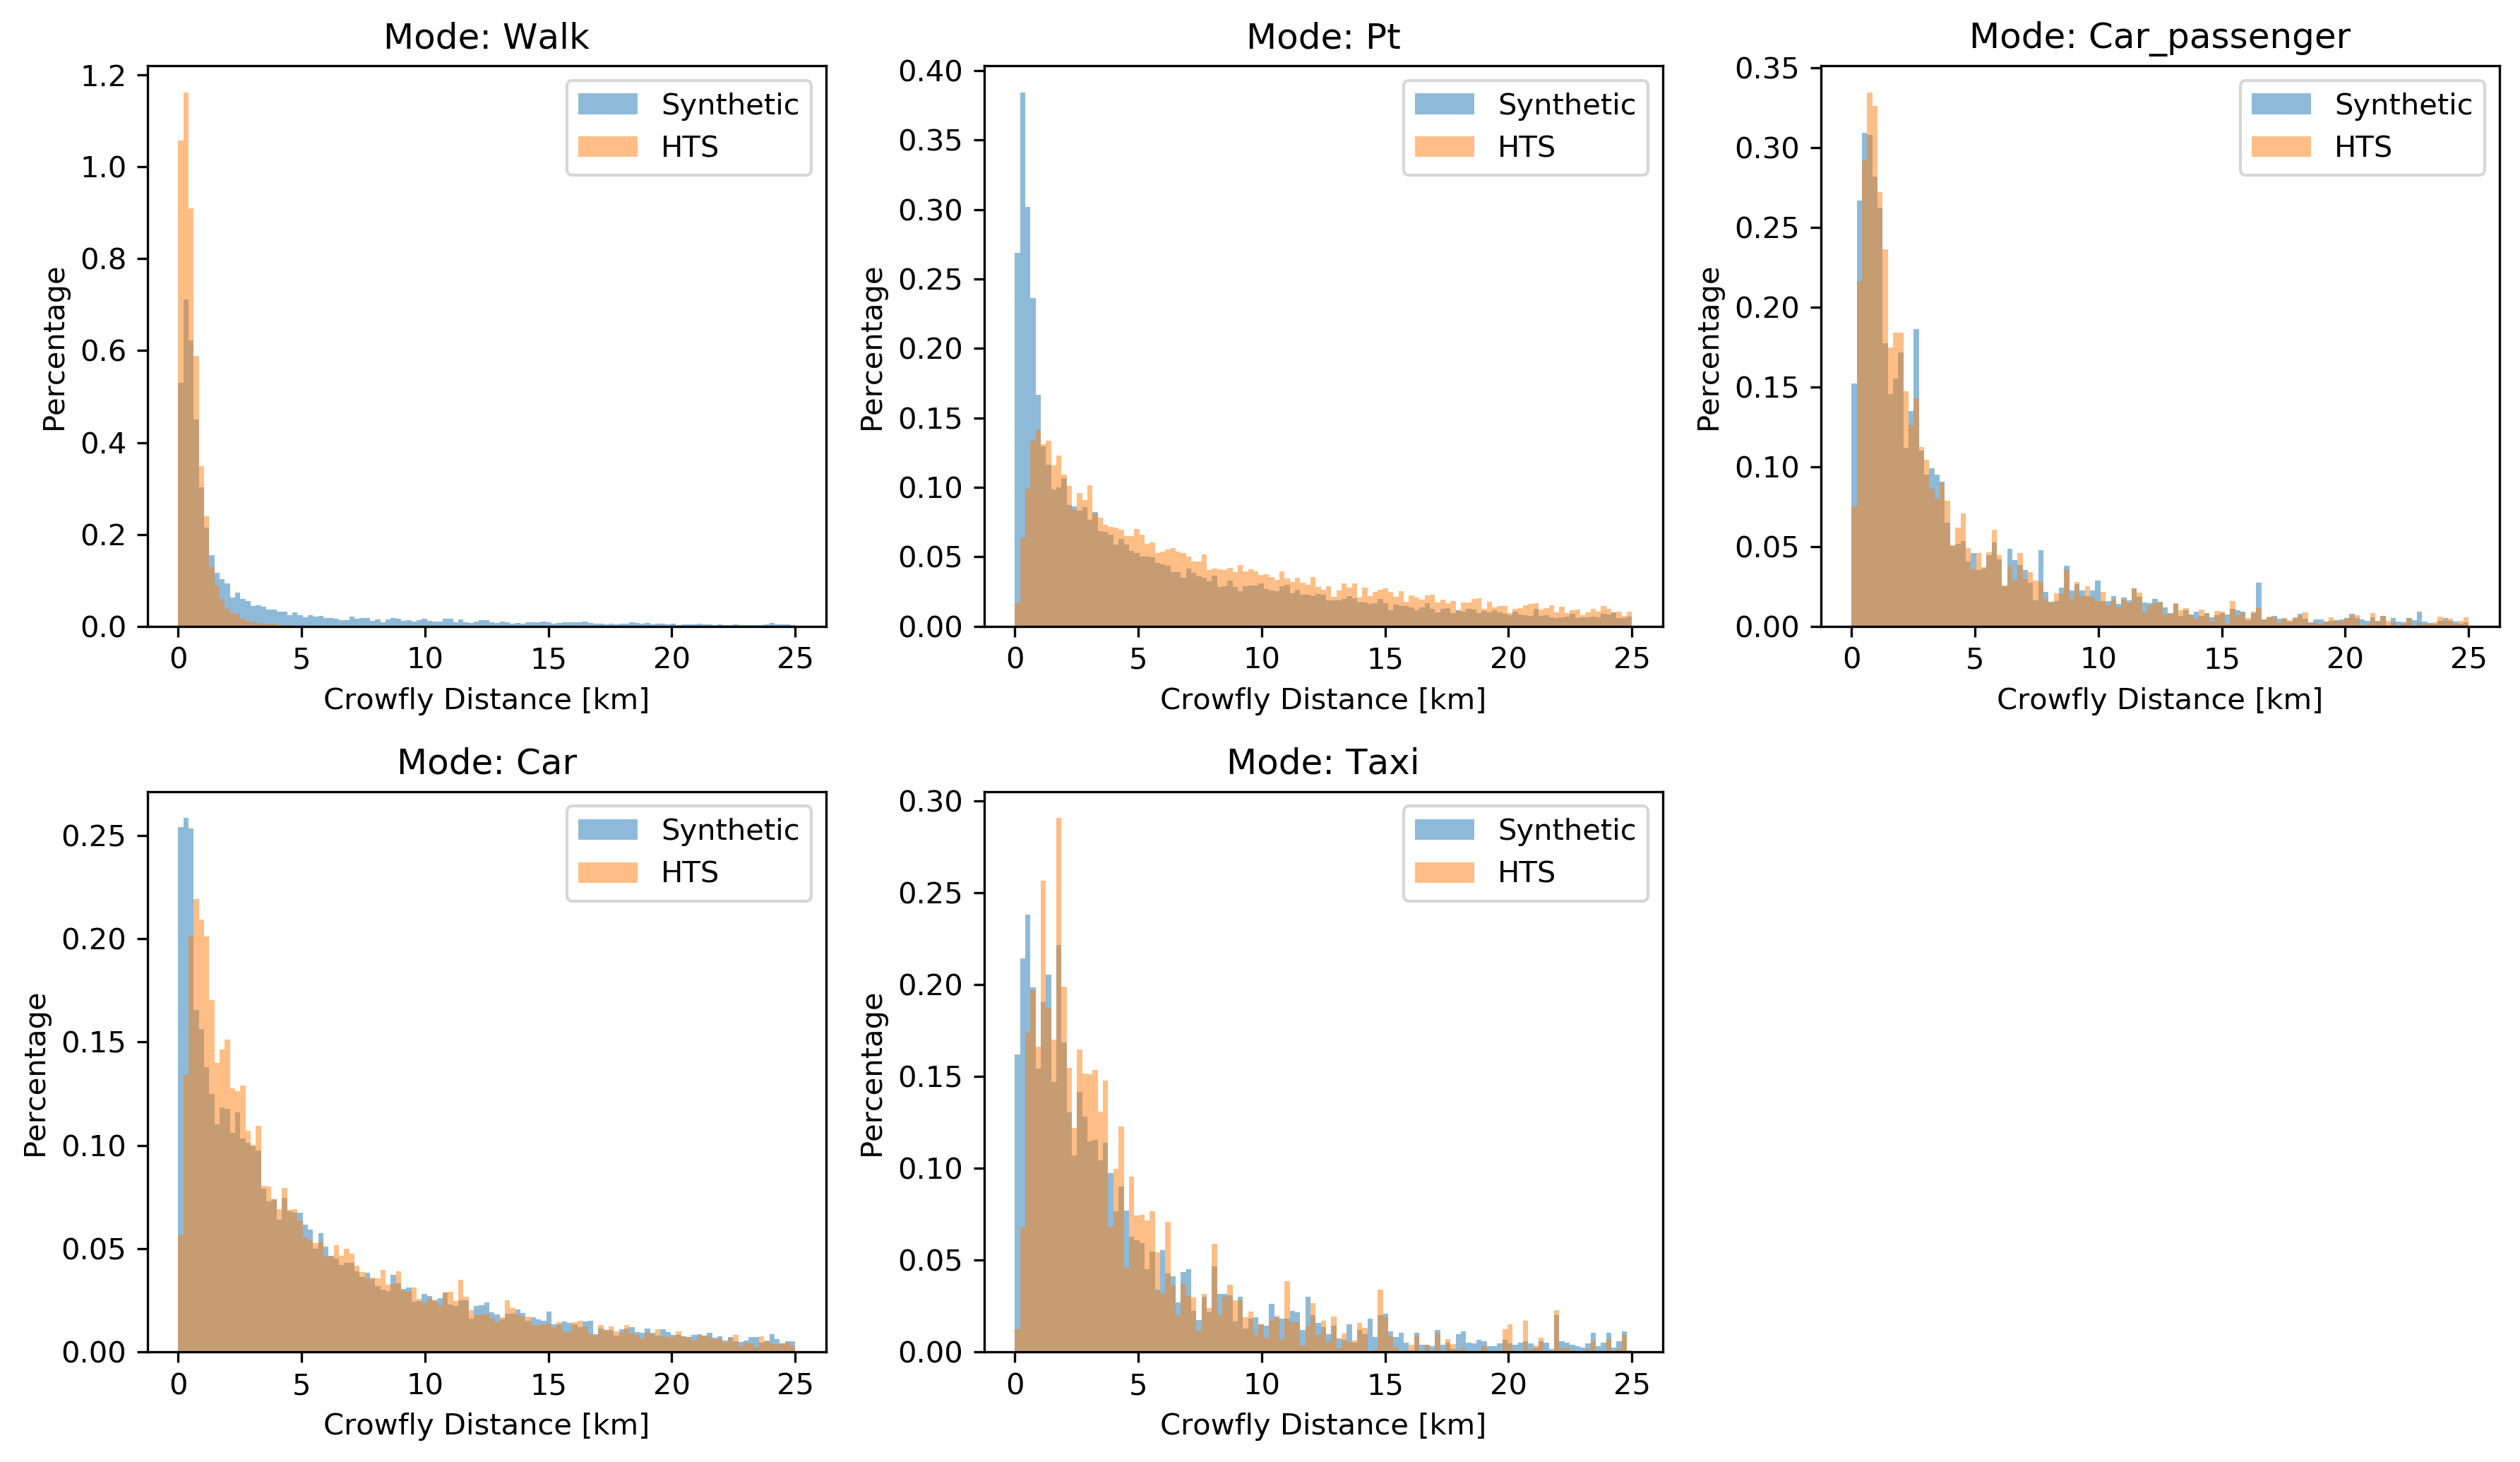

In [734]:
modelist=df2["mode"].unique()
plt.rcParams['figure.dpi'] = 300

cols = 3
rows = 2

fig, axes = plt.subplots(nrows=rows, ncols=cols)
bins=np.linspace(0, 25, 120)
idx=0
for r in range(rows):
    for c in range(cols):
        x = df2[df2["mode"]==modelist[idx]]["crowfly_distance"]
        y = amdf2[amdf2["mode"]==modelist[idx]][["crowfly_distance", "weight_person"]]        
        axes[r,c].hist(x,bins,alpha=0.5,label="Synthetic",density=True)
        axes[r,c].hist(y["crowfly_distance"],bins,weights=y["weight_person"],alpha=0.5,label='HTS',density=True)
        axes[r,c].set_ylabel("Percentage")
        axes[r,c].set_xlabel("Crowfly Distance [km]")
        axes[r,c].set_title("Mode: "+modelist[idx].capitalize())
        axes[r,c].legend(loc="best")
        
        idx=idx+1
        if idx==5:
            break
fig.delaxes(axes[1,2])        
fig.tight_layout()
fig.show()
plt.savefig("distancemodehist.png")


In [735]:
# zipping modes in correct order
modes = zip(np.sort(df["mode"].unique()),["car","car_passenger","pt", "taxi", "walk"])

### Mode share

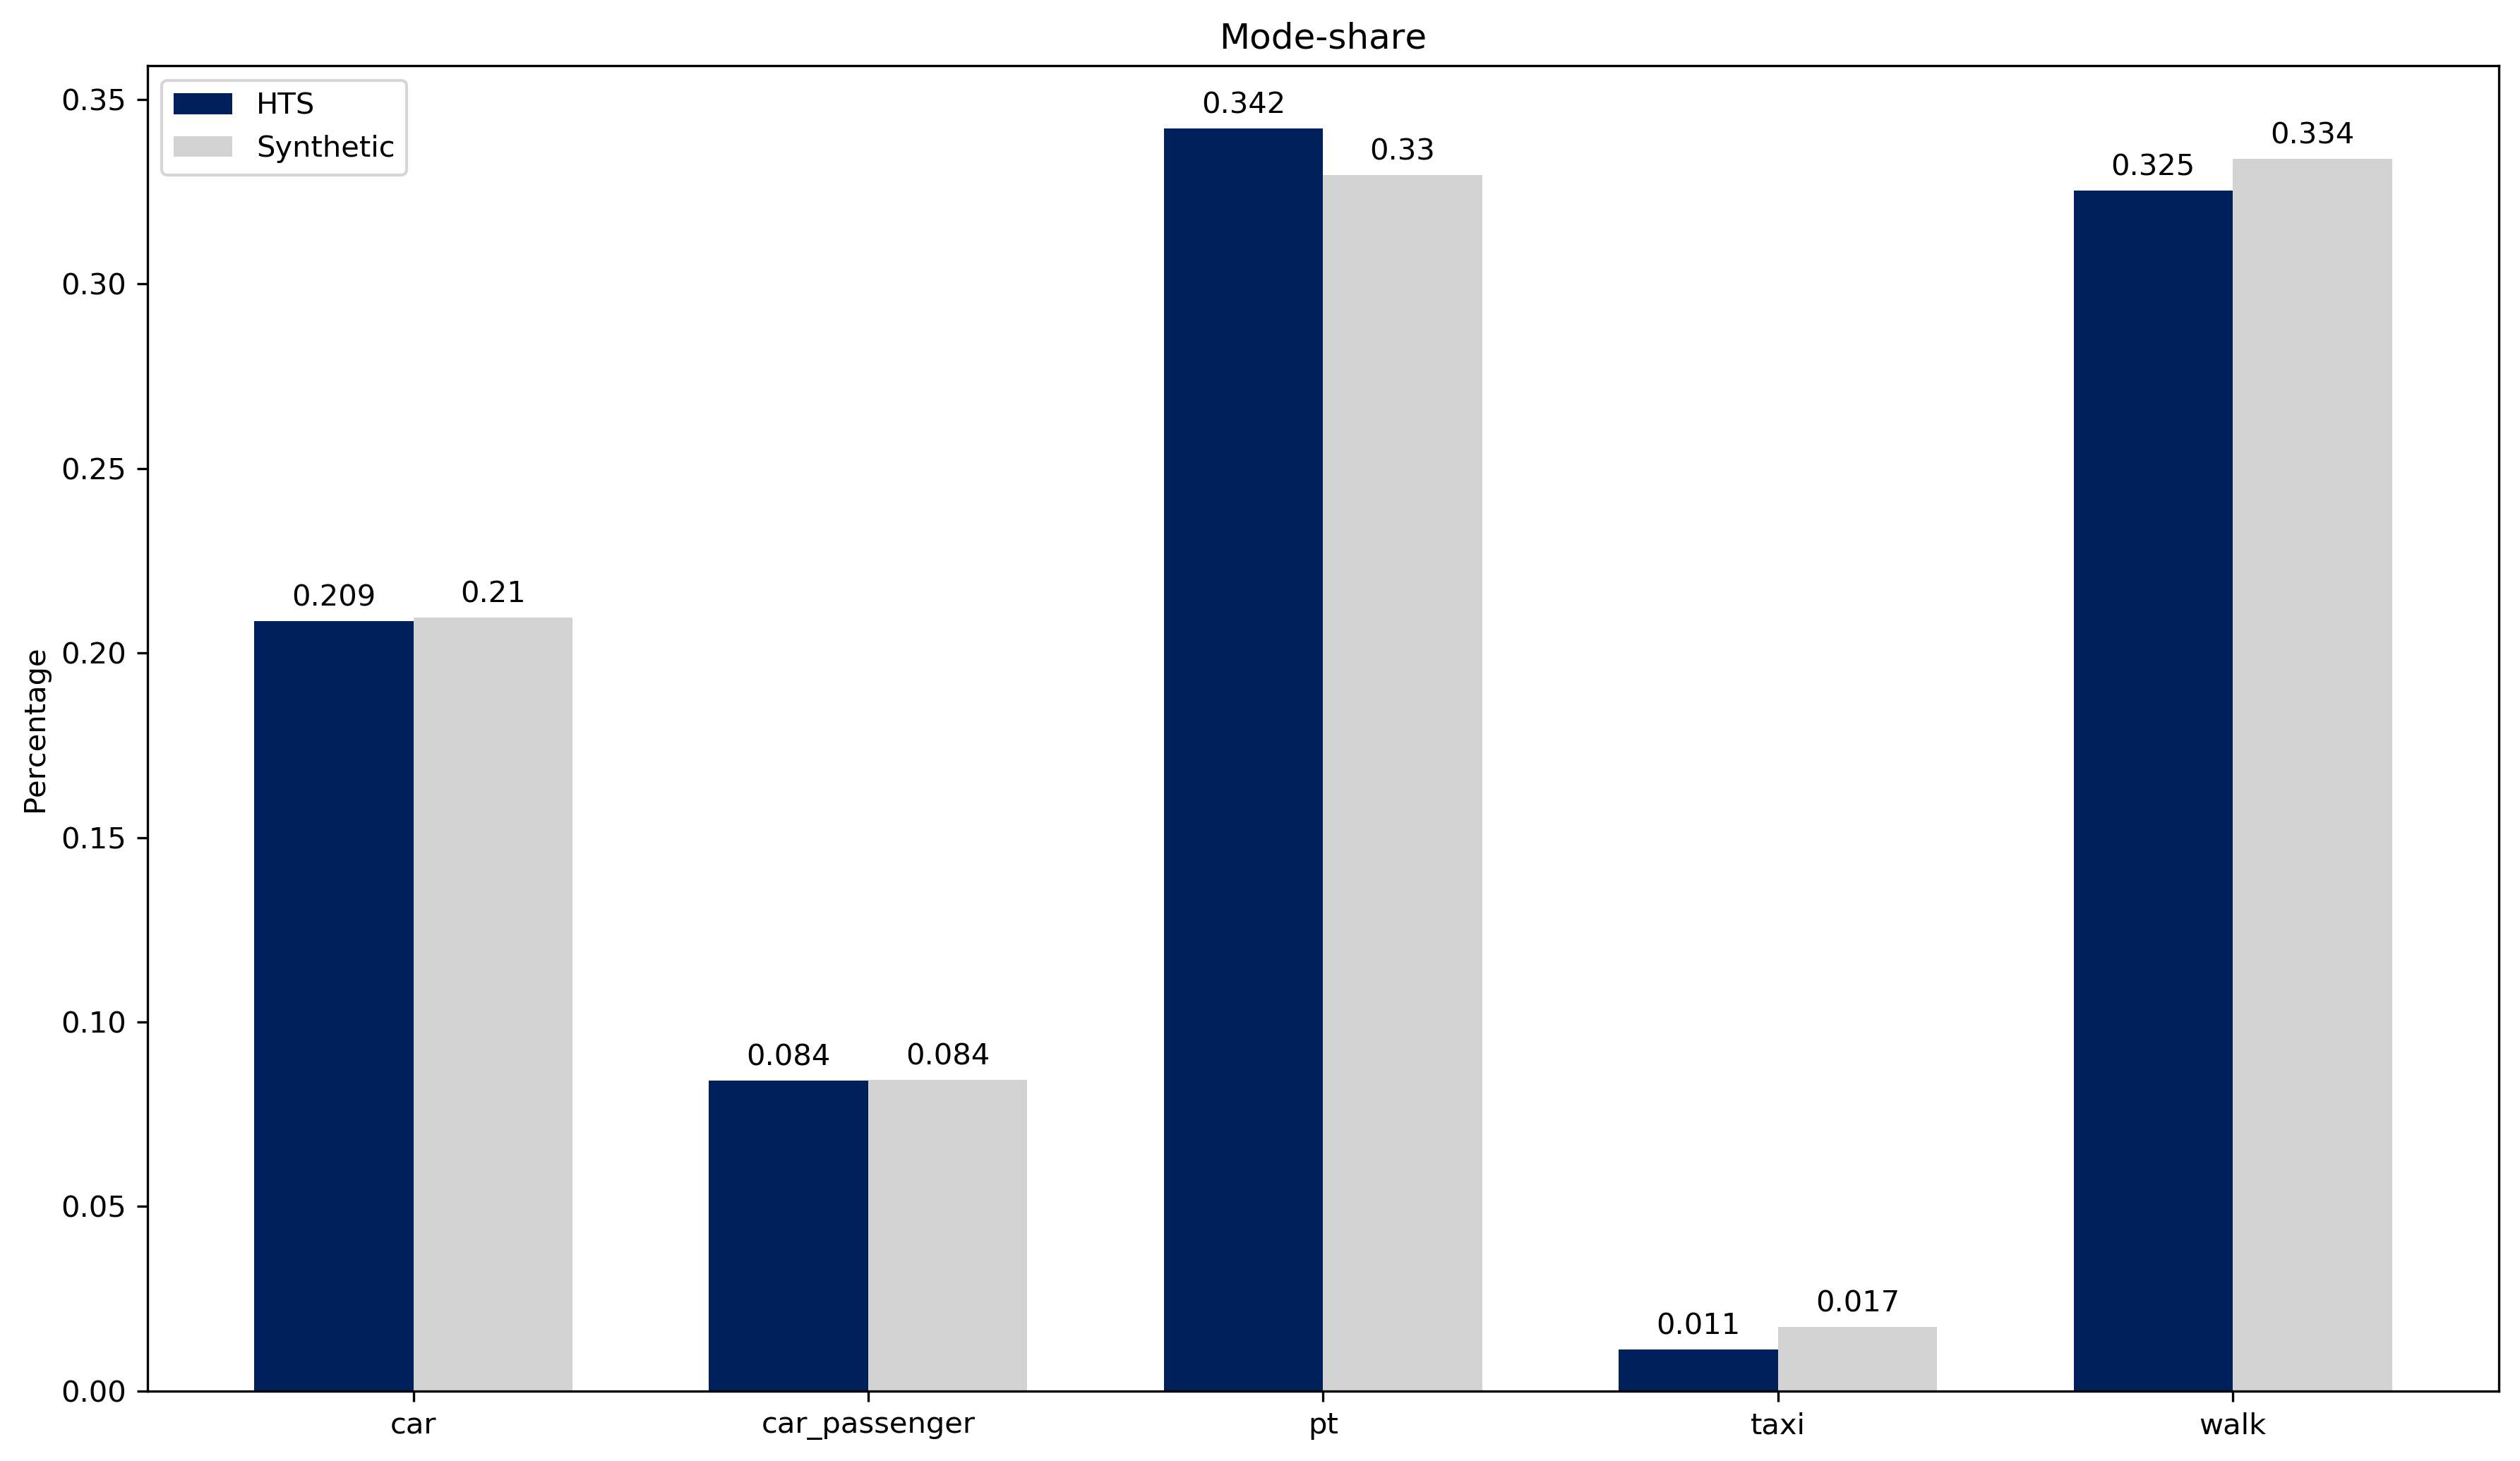

In [736]:
# Mode-share 

modelist=list(zip(np.sort(df["mode"].unique()),["car","car_passenger","pt", "taxi", "walk"]))
plt.rcParams['figure.dpi'] = 300

y1 = []
y2 = []
for mode,mode_cat in modelist:
    y1.append(df2[df2["mode"]==mode]["crowfly_distance"].count() / len(df))
    #y2.append(amdf[amdf["mode_cat"]==mode_cat]["air_dist_km"].count() / len(amdf))
    # use person weight for weigthing instead
    y2.append(amdf2[amdf2["mode"]==mode_cat]["weight_person"].sum() / amdf["weight_person"].sum())
    
labels = [i[0] for i in modelist]


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y2, width, label='HTS',color="#00205B")
rects2 = ax.bar(x + width/2, y1, width, label='Synthetic',color="#D3D3D3")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Mode-share')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height,3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig("modeshare.png")

#plt.show()


### overall percentage of mode share for modes

In [737]:
df["crowfly_distance_km"]=df["crowfly_distance"]*0.001
bins = np.linspace(0, 20, 21)

data = []
adata = []
for mode,mode_cat in modelist:
    data.append(np.histogram(df[df["mode"]==mode]["crowfly_distance_km"],bins=bins)[0])
    #adata.append(np.histogram(amdf[amdf["mode_cat"]==mode_cat]["air_dist_km"],bins=bins)[0])
    # weight by person weight for actual data
    # from docu: "Each value only contributes its associated weight towards the bin count (instead of 1)"
    adata.append(np.histogram(amdf[amdf["mode"]==mode_cat]["crowfly_distance"],
                              bins=bins,
                              weights = amdf[amdf["mode"]==mode_cat]["weight_person"])
                 [0])
data = np.array(data)
adata = np.array(adata)

In [738]:
totals = [data[:,i].sum() for i in range(len(data[0]))]
atotals = [adata[:,i].sum() for i in range(len(adata[0]))]

In [739]:
# normalize and reformat
dn = np.array([(data[:,i]/totals[i]*100) for i in range(len(data[0]))])
adn = np.array([(adata[:,i]/atotals[i]*100) for i in range(len(adata[0]))])

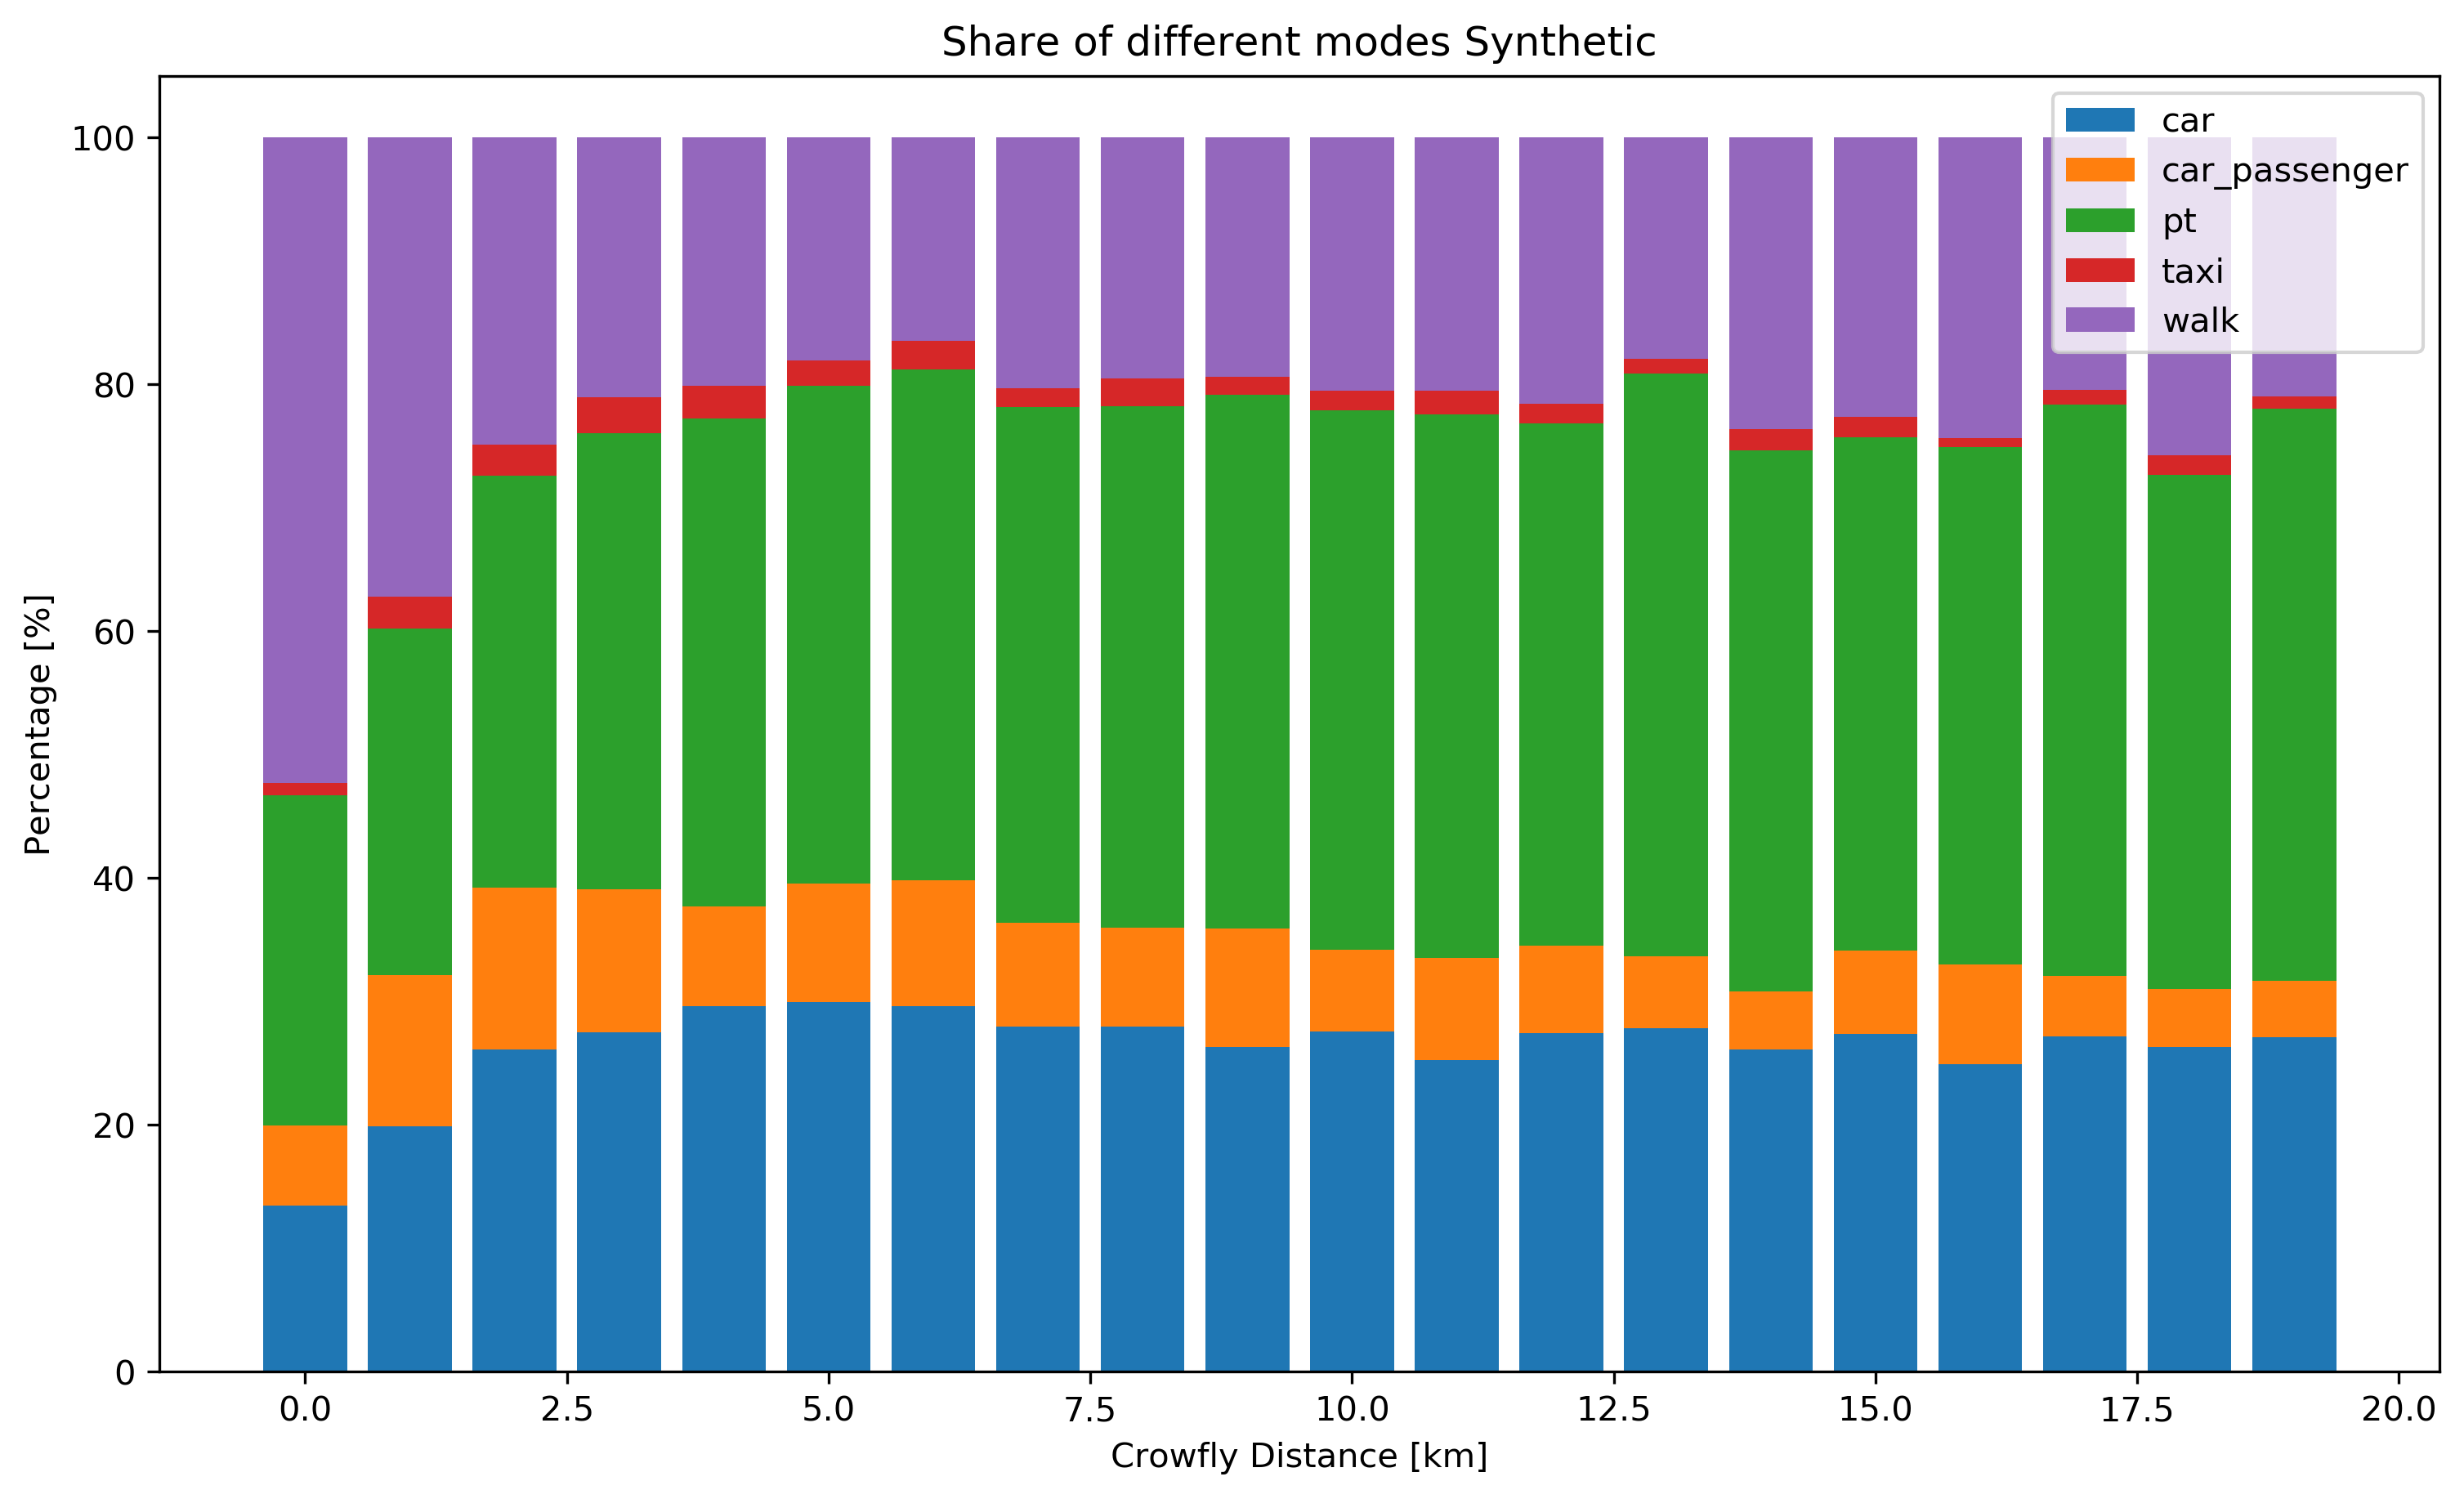

In [740]:
r = bins[:-1]
for i,mode in enumerate(modelist):
    plt.bar(r,dn[:,i],bottom=dn[:,:i].sum(axis=1),label=mode[0])
plt.xlabel("Crowfly Distance [km]")    
plt.ylabel("Percentage [%]")
plt.title("Share of different modes Synthetic")
plt.legend(loc="best")
plt.show()

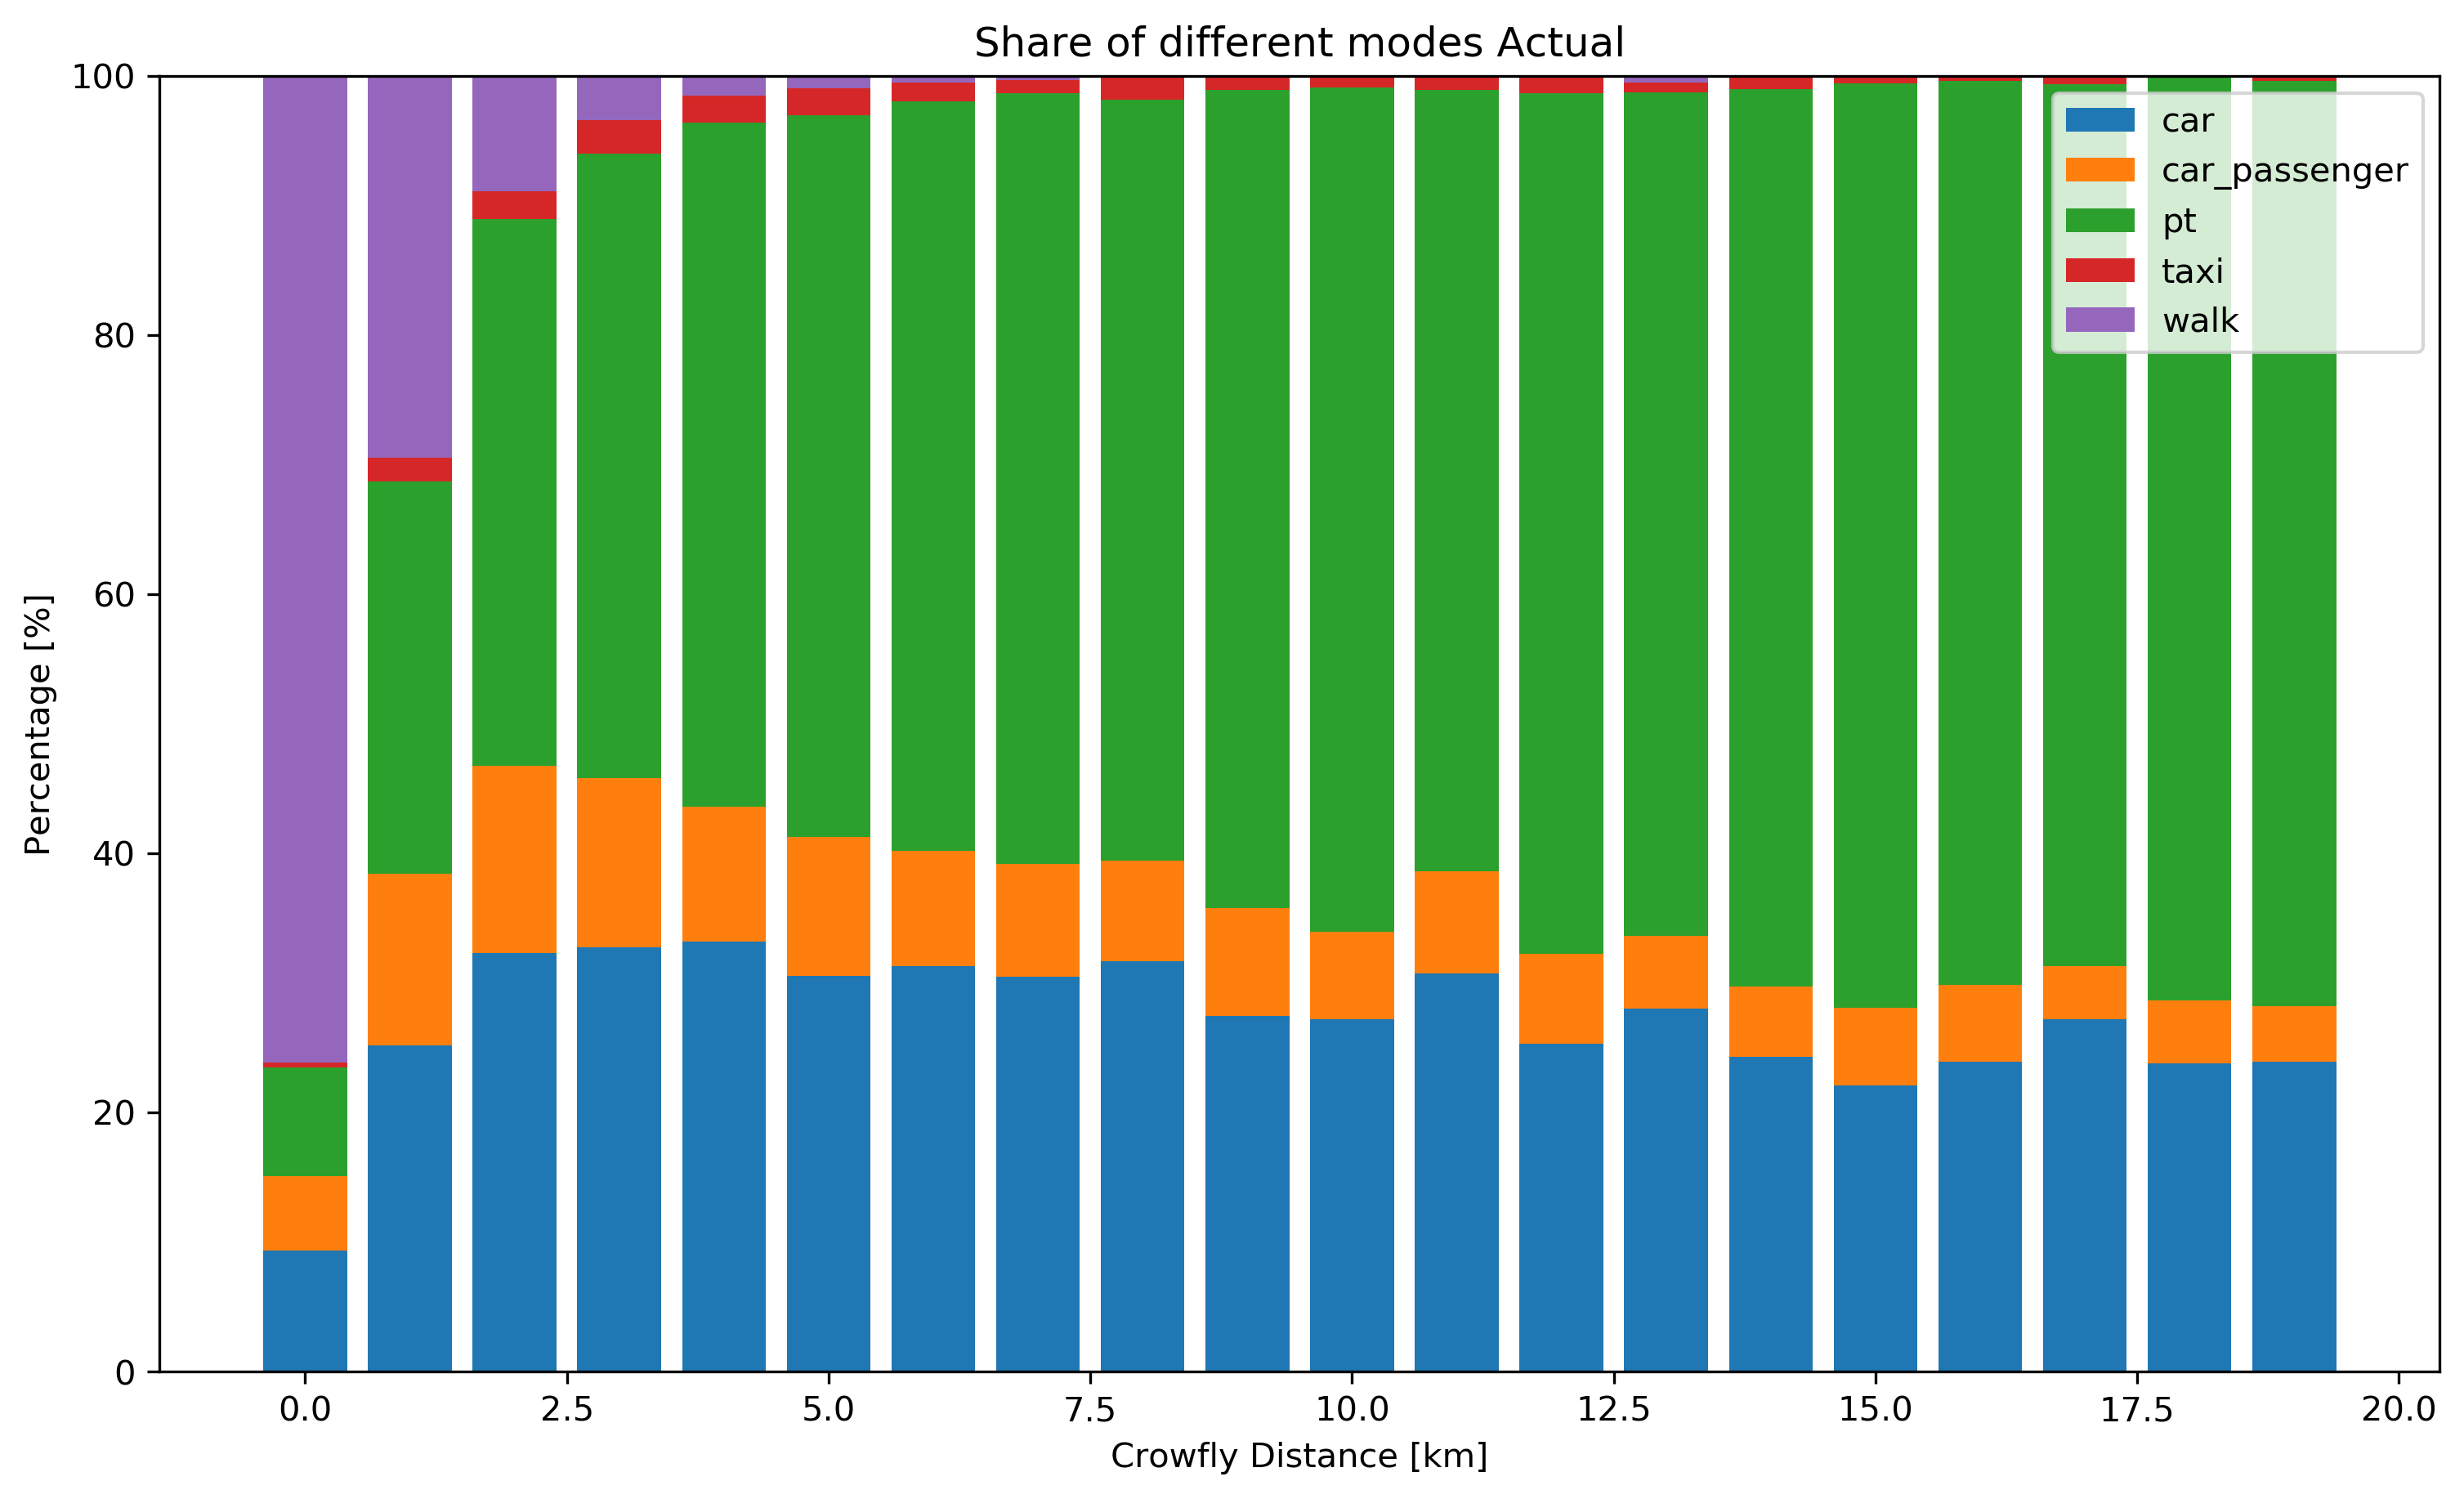

In [741]:
r = bins[:-1]
for i,mode in enumerate(modelist):
    plt.bar(r,adn[:,i],bottom=adn[:,:i].sum(axis=1),label=mode[0])
plt.xlabel("Crowfly Distance [km]")    
plt.ylabel("Percentage [%]")
plt.title("Share of different modes Actual")
plt.legend(loc="best")
plt.show()

C:\APPS\Anaconda3\envs\scenarios\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


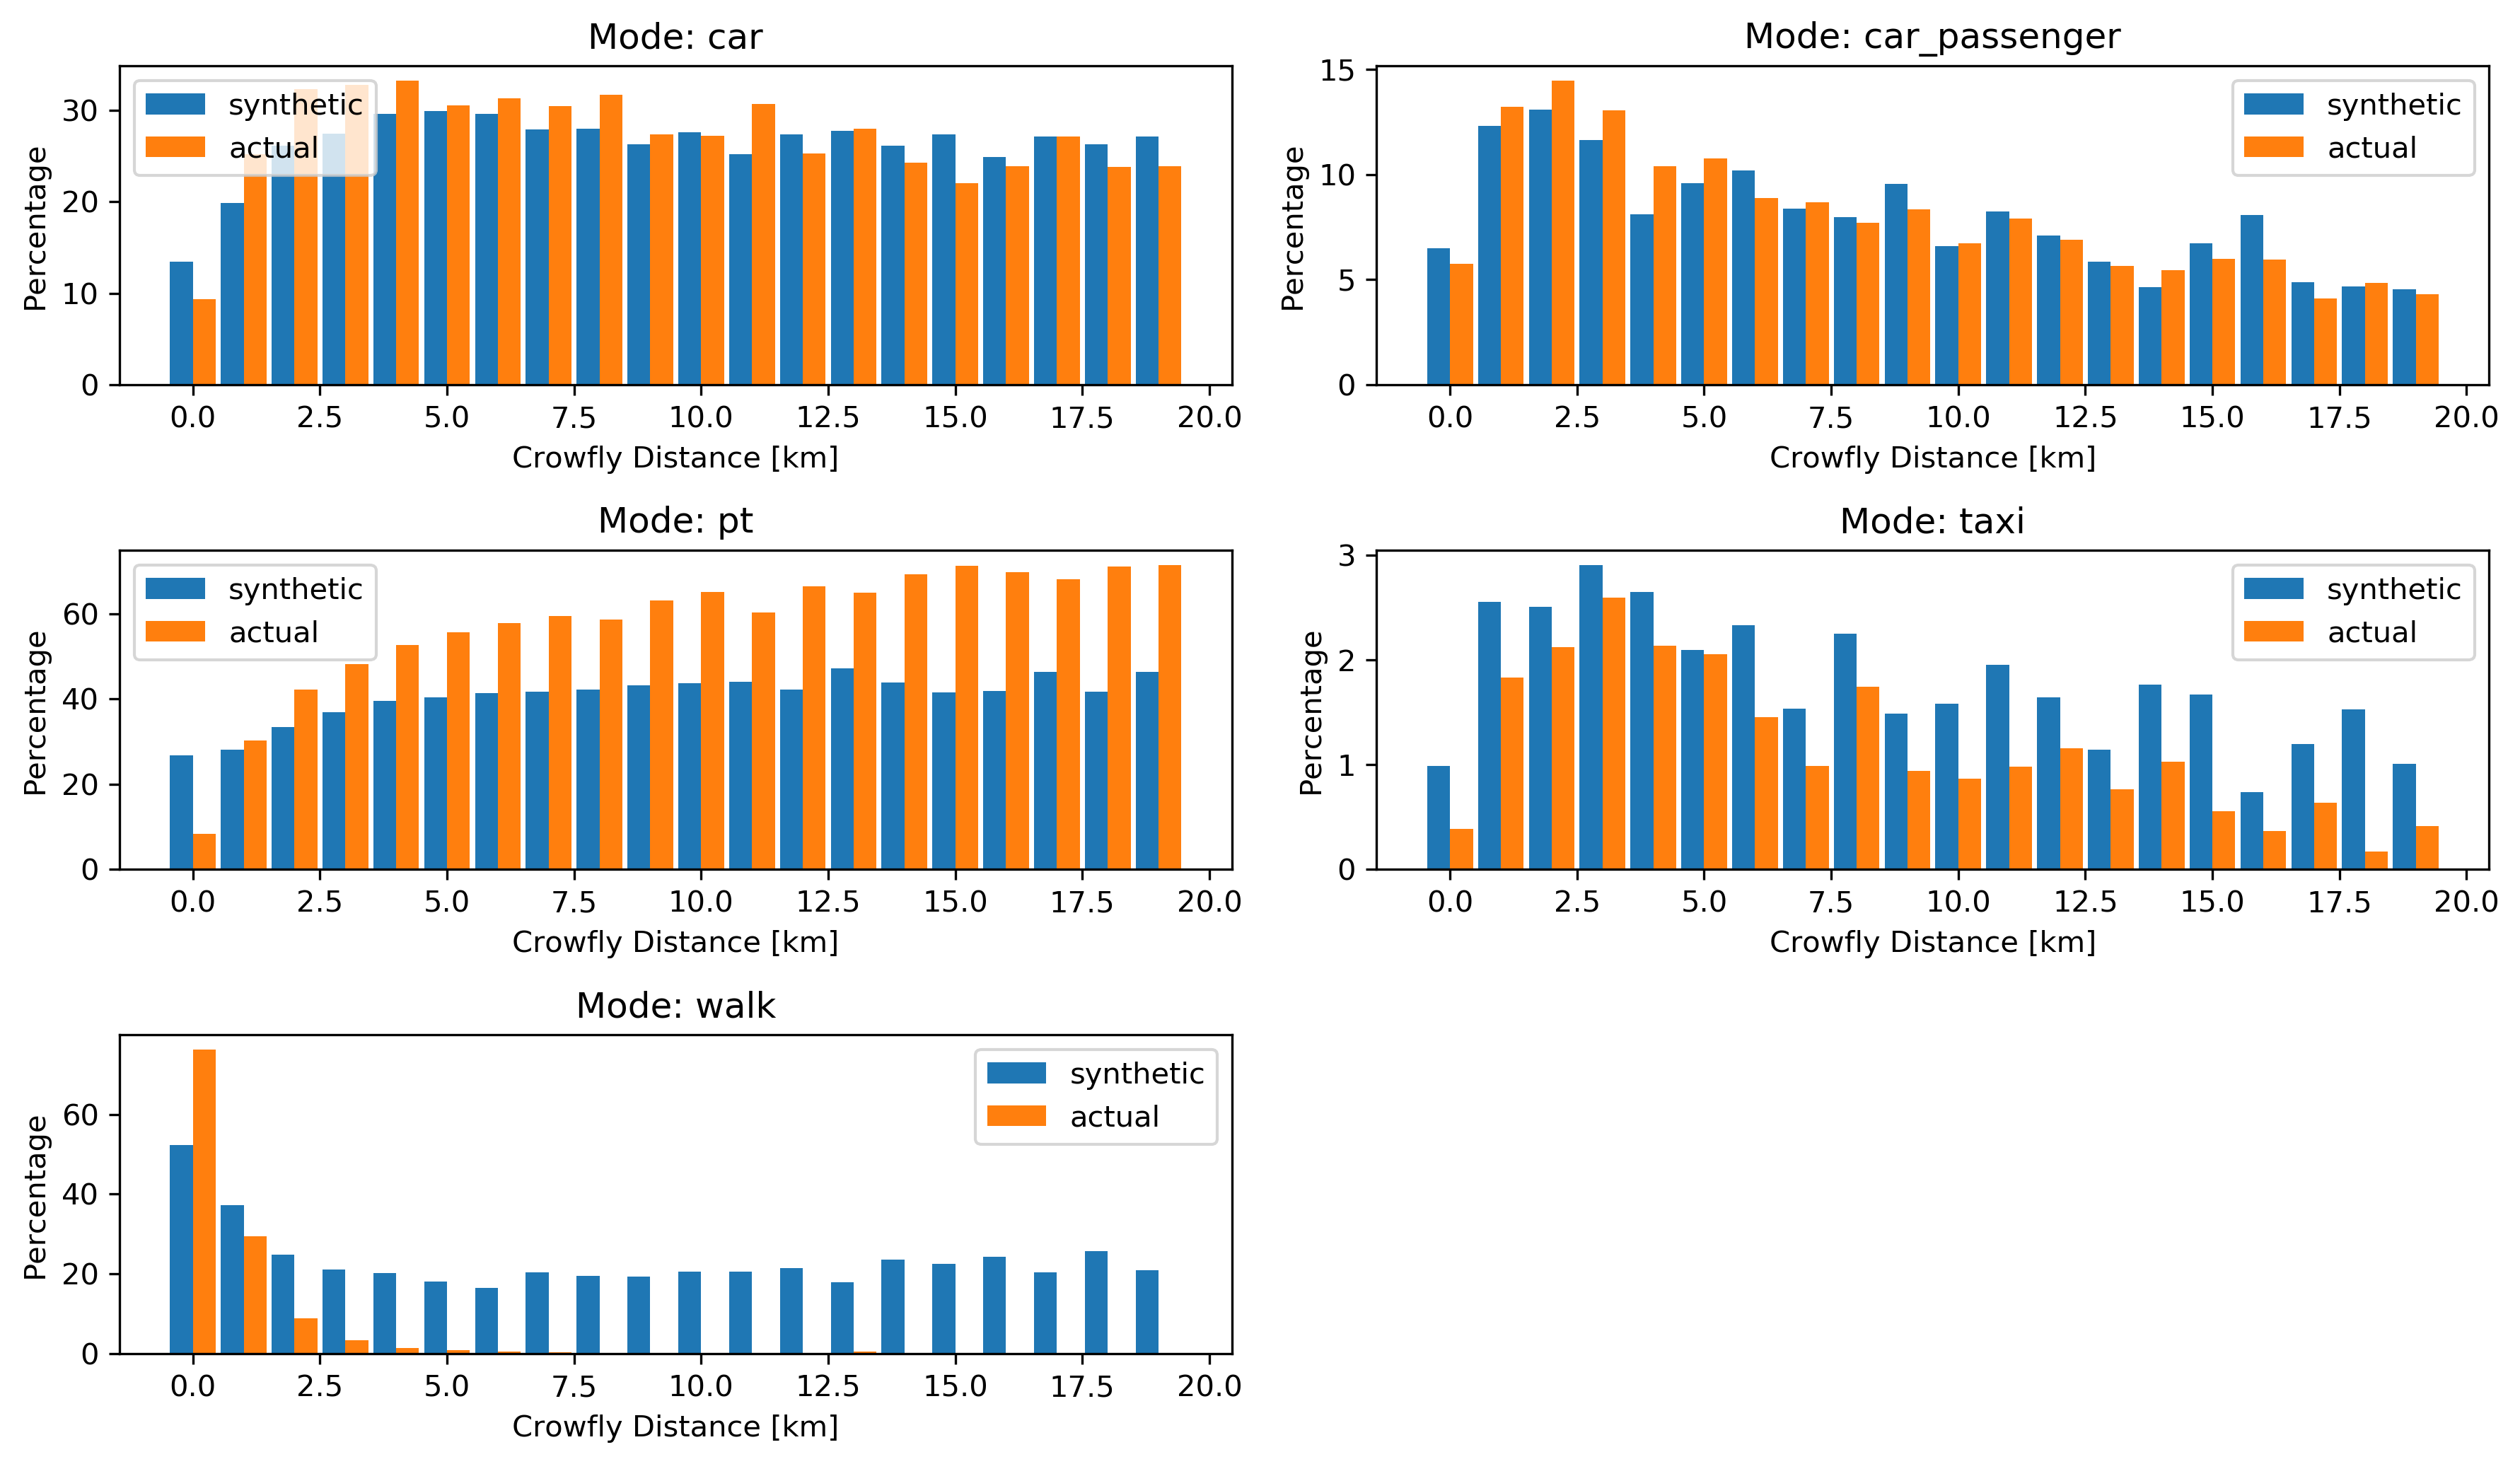

In [742]:
# now plotting each mode on its own

modelist=list(zip(np.sort(df["mode"].unique()),["car","car_passenger","pt", "walk", "taxi"]))
plt.rcParams['figure.dpi'] = 300

cols = 2
rows = 3

x = bins[:-1]

fig, axes = plt.subplots(nrows=rows, ncols=cols)
width = 0.45
idx=0
for r in range(rows):
    for c in range(cols):
        y1 = dn[:,idx]
        y2 = adn[:,idx]     
        #axes[r,c].hist(x.sample(len(y)),bins,alpha=0.5,label="synthetic")
        axes[r,c].bar(x - width/2, y1, width, label='synthetic')
        axes[r,c].bar(x + width/2, y2, width, label='actual')
        axes[r,c].set_ylabel("Percentage")
        axes[r,c].set_xlabel("Crowfly Distance [km]")
        
        axes[r,c].set_title("Mode: "+modelist[idx][0])
        axes[r,c].legend(loc="best")
        
        idx=idx+1
        if idx==5:
            break
fig.delaxes(axes[2,1])   
fig.tight_layout()
fig.show()
plt.savefig("SP_ModeShare_DistanceBins_Shopping_4.png")


In [743]:
df[(df["mode"]=="car") & (df["age"]>70)]

,person_id,trip_id,preceeding_activity_index,following_activity_index,departure_time,arrival_time,mode,preceeding_purpose,following_purpose,geometry,household_id,age,employment,sex,has_pt_subscription,census_person_id,hts_person_id,crowfly_distance,crowfly_distance_km
28,1259,0,0,1,43447.0,45547.0,car,home,other,"LINESTRING (333841.916 7400183.014, 343683.376...",351,88,no,female,True,74922,3231800103,9849.272172,9.849272
29,1259,1,1,2,57847.0,59947.0,car,other,home,"LINESTRING (343683.376 7400575.213, 333841.916...",351,88,no,female,True,74922,3231800103,9849.272172,9.849272
1106,64622,0,0,1,36324.0,37524.0,car,home,other,"LINESTRING (318825.985 7398183.305, 319325.008...",20189,72,no,male,True,78866,5060687101,2425.976757,2.425977
1107,64622,1,1,2,54324.0,55524.0,car,other,shop,"LINESTRING (319325.008 7395809.207, 317185.857...",20189,72,no,male,True,78866,5060687101,3292.497152,3.292497
1108,64622,2,2,3,57324.0,57924.0,car,shop,home,"LINESTRING (317185.857 7398312.120, 318825.985...",20189,72,no,male,True,78866,5060687101,1645.178864,1.645179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367331,19874142,3,3,4,68460.0,69960.0,car,work,home,"LINESTRING (324772.392 7391565.391, 316469.337...",6174231,71,no,male,True,290762,2721800101,9047.712070,9.047712
367431,19879065,0,0,1,27258.0,29658.0,car,home,work,"LINESTRING (340791.541 7396373.368, 364132.652...",6175760,76,yes,male,True,291080,1510024101,23499.902398,23.499902
367434,19879065,3,3,4,63258.0,65058.0,car,work,home,"LINESTRING (364132.652 7393646.103, 340791.541...",6175760,76,yes,male,True,291080,1510024101,23499.902398,23.499902
367435,19879066,0,0,1,45540.0,46740.0,car,home,other,"LINESTRING (340791.541 7396373.368, 337858.248...",6175760,76,yes,male,True,291080,3030751101,4180.932827,4.180933


### Add geo location to origin and destination in synthetic

In [744]:
# load shapefile and convert to correct projection
df_zones = gpd.read_file("spatial_df.shp")
df_zones = df_zones.to_crs({"init" : "epsg:4326"})


In [745]:
# origin GEOID
df["geometry"] = [geo.Point(*xy) for xy in zip(df["origin_x"], df["origin_y"])]
df_geo = gpd.GeoDataFrame(df, crs = {"init" : "epsg:29183"})
df_geo = df_geo.to_crs({"init" : "epsg:4326"})
# only take necessary rows into account to speed up process
pt_zones = gpd.sjoin(df_geo[["person_id","person_trip_id","geometry"]], df_zones[["c_1_633_","geometry"]], op = "within",how="left")
# we ensure with the sjoin how="left" parameter, that GEOID is in the correct order
df["ori_geoloc"] = pt_zones["c_1_633_"]

KeyError: 'origin_x'

In [ ]:
# destination GEOID
df["geometry"] = [geo.Point(*xy) for xy in zip(df["destination_x"], df["destination_y"])]
df_geo = gpd.GeoDataFrame(df, crs = {"init" : "epsg:29183"})
df_geo = df_geo.to_crs({"init" : "epsg:4326"})
pt_zones = gpd.sjoin(df_geo[["person_id","person_trip_id","geometry"]], df_zones[["c_1_633_","geometry"]], op = "within",how="left")
# we ensure with the sjoin how="left" parameter, that GEOID is in the correct order
df["dest_geoloc"] = pt_zones["c_1_633_"]

In [ ]:
df.drop(columns=["geometry"],inplace=True)

In [ ]:
amdf['person_id'] = amdf.index

In [ ]:
# origin GEOID
amdf["geometry"] = [geo.Point(*xy) for xy in zip(amdf["origin_x"], amdf["origin_y"])]
df_geo = gpd.GeoDataFrame(amdf, crs = {"init" : "epsg:29183"})
df_geo = df_geo.to_crs({"init" : "epsg:4326"})
# only take necessary rows into account to speed up process
pt_zones = gpd.sjoin(df_geo[["person_id","trip_id","geometry"]], df_zones[["c_1_633_","geometry"]], op = "within",how="left")
# we ensure with the sjoin how="left" parameter, that GEOID is in the correct order
amdf["ori_geoloc"] = pt_zones["c_1_633_"]

In [ ]:
# destination GEOID
amdf["geometry"] = [geo.Point(*xy) for xy in zip(amdf["destination_x"], amdf["destination_y"])]
df_geo = gpd.GeoDataFrame(amdf, crs = {"init" : "epsg:29183"})
df_geo = df_geo.to_crs({"init" : "epsg:4326"})
pt_zones = gpd.sjoin(df_geo[["person_id","trip_id","geometry"]], df_zones[["c_1_633_","geometry"]], op = "within",how="left")
# we ensure with the sjoin how="left" parameter, that GEOID is in the correct order
amdf["dest_geoloc"] = pt_zones["c_1_633_"]

### Check county-county mode share

In [ ]:
# create county-county dataframes
cdf = df[df["ori_geoloc"] == df["dest_geoloc"]]
#cdf = cdf[~cdf["ori_geoloc"].astype("str").str.startswith("06075")]
#cdf = cdf[~cdf["dest_geoloc"].astype("str").str.startswith("06075")]

camdf = amdf[amdf["ori_geoloc"] == amdf["dest_geoloc"]]
#camdf = camdf[~camdf["origin_zone"].astype("str").str.startswith("6075")]
#camdf = camdf[~camdf["destination_zone"].astype("str").str.startswith("6075")]


In [ ]:
#Mode-share 

modelist=list(zip(np.sort(df["mode"].unique()),["car","car_passenger","pt", "taxi", "walk"]))
plt.rcParams['figure.dpi'] = 300

y1 = []
y2 = []
for mode,mode_cat in modelist:
    y1.append(cdf[cdf["mode"]==mode]["crowfly_distance"].count() / len(cdf))
    #y2.append(camdf[camdf["mode_cat"]==mode_cat]["air_dist_km"].count() / len(camdf))
    # use person weight for weigthing instead
    y2.append(camdf[camdf["mode"]==mode_cat]["weight_person"].sum() / camdf["weight_person"].sum())

labels = [i[0] for i in modelist]


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y2, width, label='HTS',color="#00205B")
rects2 = ax.bar(x + width/2, y1, width, label='Synthetic',color="#D3D3D3")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Zone-Zone Mode-share')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height,3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig("SP_WithinZone_ModeShare.png")

plt.show()

In [ ]:
# share diagrams for county-county share km wise
bins = np.linspace(0, 50, 51)

data = []
adata = []
for mode,mode_cat in modelist:
    data.append(np.histogram(cdf[cdf["mode"]==mode]["crowfly_distance"],bins=bins)[0])
    #adata.append(np.histogram(camdf[camdf["mode_cat"]==mode_cat]["air_dist_km"],bins=bins)[0])
    # weight by person weight for actual data
    # from docu: "Each value only contributes its associated weight towards the bin count (instead of 1)"
    adata.append(np.histogram(camdf[camdf["mode"]==mode_cat]["crowfly_distance"],
                              bins=bins,
                              weights = camdf[camdf["mode"]==mode_cat]["weight_person"])
                 [0])
data = np.array(data)
adata = np.array(adata)

totals = [data[:,i].sum() for i in range(len(data[0]))]
atotals = [adata[:,i].sum() for i in range(len(adata[0]))]

# normalize and reformat
dn = np.array([(data[:,i]/totals[i]*100) for i in range(len(data[0]))])
adn = np.array([(adata[:,i]/atotals[i]*100) for i in range(len(adata[0]))])

r = bins[:-1]
for i,mode in enumerate(modelist):
    plt.bar(r,dn[:,i],bottom=dn[:,:i].sum(axis=1),label=mode[0])
plt.xlabel("Crowfly Distance [km]")    
plt.ylabel("Percentage [%]")
plt.title("Share of different modes Synthetic")
plt.legend(loc="best")
plt.show()

r = bins[:-1]
for i,mode in enumerate(modelist):
    plt.bar(r,adn[:,i],bottom=adn[:,:i].sum(axis=1),label=mode[0])
plt.xlabel("Crowfly Distance [km]")    
plt.ylabel("Percentage [%]")
plt.title("Share of different modes Actual")
plt.legend(loc="best")
plt.show()

# now plotting each mode on its own

modelist=list(zip(np.sort(df["mode"].unique()),["car_alone","carpooled","pt","bicycle_walk"]))
plt.rcParams['figure.dpi'] = 100

cols = 2
rows = 2

x = bins[:-1]

fig, axes = plt.subplots(nrows=rows, ncols=cols)
width = 0.35
idx=0
for r in range(rows):
    for c in range(cols):
        y1 = dn[:,idx]
        y2 = adn[:,idx]
        
        #axes[r,c].hist(x.sample(len(y)),bins,alpha=0.5,label="synthetic")
        axes[r,c].bar(x - width/2, y1, width, label='synthetic')
        axes[r,c].bar(x + width/2, y2, width, label='actual')
        axes[r,c].set_ylabel("Percentage")
        axes[r,c].set_xlabel("Crowfly Distance [km]")
        
        axes[r,c].set_title("Mode: "+modelist[idx][0])
        axes[r,c].legend(loc="best")
        
        idx=idx+1
        
fig.tight_layout()
fig.show()

### Mode Share by departure time

In [ ]:
# comparing different modes for actual and synthetic

modelist=list(zip(np.sort(df["mode"].unique()),["car","car_passenger","pt", "taxi", "walk"]))
plt.rcParams['figure.dpi'] = 300


cols = 2
rows = 2

fig, axes = plt.subplots(nrows=rows, ncols=cols)

bins=np.linspace(0, 24, 25)
idx=0
for r in range(rows):
    for c in range(cols):
        x = df[df["mode"]==modelist[idx][0]]["start_time"]/3600  # divide by 3600 to get hours
        # for amdf need to convert from local format hh:mm:ss to hours
        hours = pd.to_timedelta(amdf[amdf["mode"]==modelist[idx][1]]["departure_h"], unit='h')
        minutes = pd.to_timedelta(amdf[amdf["mode"]==modelist[idx][1]]["departure_m"], unit='m')
        y = pd.to_timedelta(hours + minutes).dt.total_seconds().to_numpy() / 3600

        
        # need to set weigths manually
        x_w = np.empty(x.shape)
        x_w.fill(1/x.shape[0])
        y_w = np.empty(y.shape)
        y_w.fill(1/y.shape[0])
        
        #axes[r,c].hist(x.sample(len(y)),bins,alpha=0.5,label="synthetic")
        axes[r,c].hist(y,bins,alpha=0.5,weights=y_w,label='HTS')
        axes[r,c].hist(x,bins,alpha=0.5,weights=x_w,label="Synthetic")
        axes[r,c].set_ylabel("Percentage")
        axes[r,c].set_xlabel("Daytime [h]")
        axes[r,c].set_title("Mode: "+modelist[idx][0])
        axes[r,c].legend(loc="best")
        
        idx=idx+1
        
fig.tight_layout()
fig.show()
plt.savefig("SP_DepartureTime.png")


In [ ]:
df_home = pd.read_csv("home.csv")
df_work = pd.read_csv("work_differentzone.csv")
df_work_zones = pd.read_csv("work_zones.csv")
df_work_zones=df_work_zones.rename({"zone_id" : "work_zone_id"}, axis = 1)

In [ ]:
df_homework = df_home.merge(df_work, on="person_id").dropna()

In [ ]:
df_homework = df_homework.merge(df_work_zones, on="person_id")

In [ ]:
df_homework["distance"] = np.sqrt((df_homework["x_x"] - df_homework["x_y"])**2 + (df_homework["y_x"] - df_homework["y_y"])**2)

In [ ]:
len(df_homework[['zone_id', 'work_zone_id', 'distance', 'household_id']]['zone_id'].unique())

In [ ]:
df_work[df_work["person_id"]==25363]

In [ ]:
df_homework["distance"].mean()

In [ ]:
df_opportunities = pd.read_csv("opportunities.csv")

In [ ]:
df_opportunities[df_opportunities["location_id"]==67365]